# From Entropy to SVI Notebook

This notebook covers the following:
- Entropy and examples
- KL divergence
- Variational distribution and mean field approximation
- Stochastic variational inference


## 1. Definition of Shannon Entropy

For a discrete random variable $X$ that can take values $x_1, \dots, x_n$ with probabilities
$p(x_i)$, the **Shannon entropy** (base 2) is defined as:

\begin{equation}
H(X) = - \sum_{i=1}^n p(x_i) \log_2 p(x_i).
\end{equation}

- We measure entropy in **bits** when we use $\log_2$.
- Entropy is **maximum** when the distribution is uniform.
- Entropy is **zero** when one outcome has probability 1 (no uncertainty).

In [ ]:
import math
from typing import Iterable

def entropy(probs: Iterable[float], base: float = 2.0) -> float:
    """Compute Shannon entropy of a discrete distribution.

    Args:
        probs: Iterable of probabilities that sum to 1.
        base: Logarithm base (2 for bits, math.e for nats, 10 for dits).

    Returns:
        Entropy in the chosen log base.
    """
    probs = list(probs)
    # Basic sanity check
    if any(p < 0 for p in probs):
        raise ValueError("Probabilities must be non-negative.")
    total = sum(probs)
    if not math.isclose(total, 1.0, rel_tol=1e-6, abs_tol=1e-6):
        raise ValueError(f"Probabilities must sum to 1 (got {total}).")

    # Compute entropy
    return -sum(p * math.log(p, base) for p in probs if p > 0.0)

entropy([0.5, 0.5])  # quick test; should be 1.0 bit

1.0

## 2. Simple Examples

Let's compute entropy for a few basic distributions.

In [ ]:
examples = {
    "Fair coin (0.5, 0.5)": [0.5, 0.5],
    "Biased coin (0.9, 0.1)": [0.9, 0.1],
    "Fair 4-sided die": [0.25] * 4,
    "Fair 6-sided die": [1/6] * 6,
    "Non-uniform 3-outcome (0.5, 0.25, 0.25)": [0.5, 0.25, 0.25],
}

for name, probs in examples.items():
    h = entropy(probs)
    print(f"{name:35s} -> H = {h:.4f} bits")

Fair coin (0.5, 0.5)                -> H = 1.0000 bits
Biased coin (0.9, 0.1)              -> H = 0.4690 bits
Fair 4-sided die                    -> H = 2.0000 bits
Fair 6-sided die                    -> H = 2.5850 bits
Non-uniform 3-outcome (0.5, 0.25, 0.25) -> H = 1.5000 bits


## 3. Helper: Build and Explore Distributions

Here we define some helper functions to:
- Create simple distributions (e.g., coin, die, peaked distributions)
- Compare entropy between them

In [ ]:
def bernoulli(p: float):
    """Return a Bernoulli distribution [p, 1-p]."""
    if not (0.0 <= p <= 1.0):
        raise ValueError("p must be in [0, 1]")
    return [p, 1 - p]

def uniform(n: int):
    """Return a uniform distribution over n outcomes."""
    if n <= 0:
        raise ValueError("n must be positive")
    return [1.0 / n] * n

# Example: how entropy changes as a coin becomes more biased
for p in [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]:
    h = entropy(bernoulli(p))
    print(f"p(heads) = {p:4.2f} -> H = {h:.4f} bits")

p(heads) = 0.00 -> H = -0.0000 bits
p(heads) = 0.10 -> H = 0.4690 bits
p(heads) = 0.25 -> H = 0.8113 bits
p(heads) = 0.50 -> H = 1.0000 bits
p(heads) = 0.75 -> H = 0.8113 bits
p(heads) = 0.90 -> H = 0.4690 bits
p(heads) = 1.00 -> H = -0.0000 bits


## 4. Empirical vs Theoretical Entropy

We can simulate data from a known distribution, estimate the probabilities from
counts, and compare the **empirical entropy** to the **true entropy**.

In [ ]:
import random
from collections import Counter

def sample_from_probs(probs, n_samples: int):
    """Draw n_samples from a discrete distribution given by probs."""
    # Outcomes are labeled as integers 0..len(probs)-1
    outcomes = list(range(len(probs)))
    return random.choices(outcomes, weights=probs, k=n_samples)

def empirical_probs(samples):
    counts = Counter(samples)
    n = len(samples)
    return [counts[i] / n for i in range(max(counts.keys()) + 1)]

# Example: biased 3-outcome distribution
true_probs = [0.6, 0.3, 0.1]
true_H = entropy(true_probs)

for n in [10, 100, 1000, 10000]:
    samples = sample_from_probs(true_probs, n)
    emp = empirical_probs(samples)
    emp_H = entropy(emp)
    print(f"n = {n:5d} | true H = {true_H:.4f}, empirical H = {emp_H:.4f}, probs ≈ {emp}")

n =    10 | true H = 1.2955, empirical H = 1.3610, probs ≈ [0.4, 0.5, 0.1]
n =   100 | true H = 1.2955, empirical H = 1.2064, probs ≈ [0.61, 0.33, 0.06]
n =  1000 | true H = 1.2955, empirical H = 1.3353, probs ≈ [0.582, 0.303, 0.115]
n = 10000 | true H = 1.2955, empirical H = 1.2987, probs ≈ [0.5975, 0.302, 0.1005]


## 5. Visualizing Entropy of a Bernoulli Variable

This plot shows how entropy changes as the success probability $p$ of a
Bernoulli random variable varies from 0 to 1.

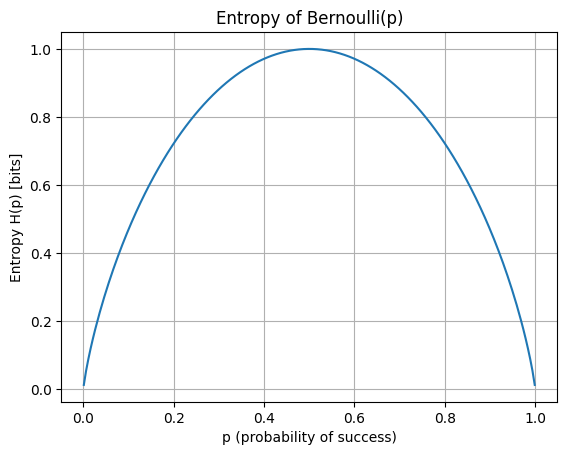

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ps = np.linspace(0.001, 0.999, 200)
Hs = [entropy([p, 1-p]) for p in ps]

plt.figure()
plt.plot(ps, Hs)
plt.xlabel("p (probability of success)")
plt.ylabel("Entropy H(p) [bits]")
plt.title("Entropy of Bernoulli(p)")
plt.grid(True)
plt.show()

## 6. Custom Distributions

Use the cell below to define your own probability distributions and compute
their entropies. For example:

```python
probs = [0.4, 0.3, 0.2, 0.1]
entropy(probs)
```

Try distributions that are:
- Very peaked (e.g., `[0.99, 0.01]`)
- Spread out (e.g., uniform over many outcomes)
and see how the entropy behaves.

In [ ]:
# Define your own distribution here and compute its entropy
my_probs = [0.4, 0.3, 0.2, 0.1]  # edit this
print("Probabilities:", my_probs)
print("Entropy =", entropy(my_probs), "bits")

Probabilities: [0.4, 0.3, 0.2, 0.1]
Entropy = 1.8464393446710154 bits



## 2) Entropy decreases as distributions get peaked (categorical)

Uniform distribution maximizes entropy; one-hot distribution has entropy 0.


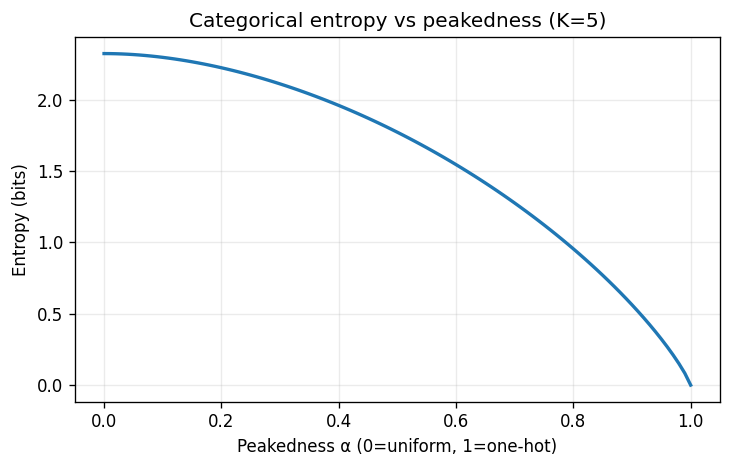

In [ ]:

K=5
alpha = np.linspace(0,1,101)
ents=[]
for a in alpha:
    dist = np.ones(K)*(1-a)/K
    dist[0] += a
    dist /= dist.sum()
    ents.append(-np.sum(dist*np.log2(dist+1e-12)))
ents=np.array(ents)

plt.figure(figsize=(6.2,4))
plt.plot(alpha, ents, lw=2)
plt.title('Categorical entropy vs peakedness (K=5)')
plt.xlabel('Peakedness α (0=uniform, 1=one-hot)')
plt.ylabel('Entropy (bits)')
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig('vi_entropy_kl_assets/figures/categorical_entropy_peakedness.png')
plt.show()



## 4) Differential entropy (Gaussian)

For $X\sim\mathcal{N}(0,\sigma^2)$:
$h(X)=\tfrac12\log(2\pi e\sigma^2).$
Bigger $\sigma$ → more spread → higher differential entropy.


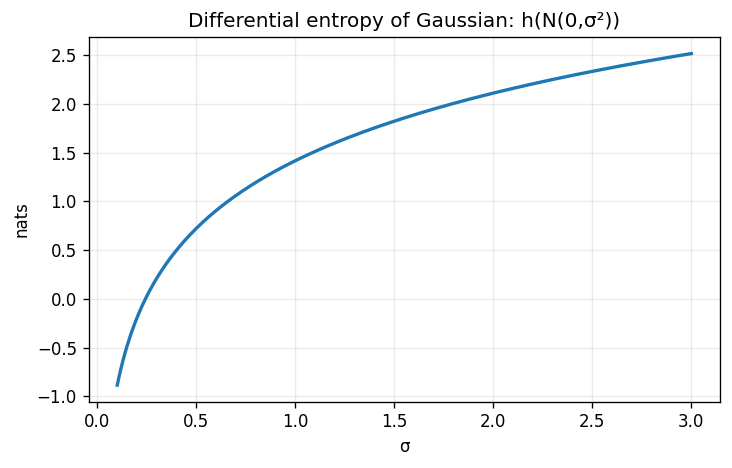

In [ ]:

sig = np.linspace(0.1, 3.0, 300)
h = 0.5*np.log(2*np.pi*np.e*sig**2)

plt.figure(figsize=(6.2,4))
plt.plot(sig, h, lw=2)
plt.title('Differential entropy of Gaussian: h(N(0,σ²))')
plt.xlabel('σ')
plt.ylabel('nats')
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig('vi_entropy_kl_assets/figures/gaussian_differential_entropy.png')
plt.show()


# KL Divergence Exploration

This notebook helps you **understand and experiment with Kullback--Leibler (KL) divergence** for discrete probability distributions.

Use it to:
- Compute KL divergence between distributions
- See examples where KL is small or large
- Visualize KL divergence for Bernoulli distributions
- Explore the relationship between KL divergence, entropy, and cross-entropy

## 1. Definition of KL Divergence (Discrete Case)

Let $P$ and $Q$ be two discrete probability distributions on the same support $\{x_1, \dots, x_n\}$, with probabilities $p_i = P(x_i)$ and $q_i = Q(x_i)$.

The **Kullback--Leibler divergence** from $Q$ to $P$ is defined as
\begin{equation}
\mathrm{KL}(P \Vert Q) = \sum_{i=1}^n p_i \log \frac{p_i}{q_i}.
\end{equation}

- KL divergence is **not symmetric**: in general, $\mathrm{KL}(P\Vert Q) \neq \mathrm{KL}(Q\Vert P)$.
- KL is always **non-negative** and equals 0 if and only if $P = Q$ (same distribution).
- Intuitively, $\mathrm{KL}(P\Vert Q)$ measures how "wasteful" it is to use $Q$ as a model when the true distribution is $P$.

In [ ]:
import math
from typing import Iterable

def kl_divergence(P: Iterable[float], Q: Iterable[float], base: float = 2.0) -> float:
    """Compute KL(P || Q) for discrete distributions.

    Args:
        P: Iterable of probabilities for the true distribution P.
        Q: Iterable of probabilities for the model distribution Q.
        base: Logarithm base (2 for bits).

    Returns:
        KL divergence KL(P || Q) in the chosen log base.
    """
    P = list(P)
    Q = list(Q)
    if len(P) != len(Q):
        raise ValueError("P and Q must have the same length.")

    if any(p < 0 for p in P) or any(q < 0 for q in Q):
        raise ValueError("Probabilities must be non-negative.")

    if not math.isclose(sum(P), 1.0, rel_tol=1e-6, abs_tol=1e-6):
        raise ValueError(f"P must sum to 1 (got {sum(P)}).")
    if not math.isclose(sum(Q), 1.0, rel_tol=1e-6, abs_tol=1e-6):
        raise ValueError(f"Q must sum to 1 (got {sum(Q)}).")

    kl = 0.0
    for p, q in zip(P, Q):
        if p == 0.0:
            continue  # 0 * log(0/q) treated as 0
        if q == 0.0:
            raise ValueError("KL divergence is infinite when Q assigns zero probability to an event with p>0.")
        kl += p * math.log(p / q, base)
    return kl

# Quick sanity check
P = [0.5, 0.5]
Q = [0.5, 0.5]
kl_divergence(P, Q)

0.0

## 2. Simple Examples

Here we compute KL divergence for a few pairs of discrete distributions.


In [ ]:
examples = [
    ("Same distributions", [0.5, 0.5], [0.5, 0.5]),
    ("Slightly different coins", [0.6, 0.4], [0.5, 0.5]),
    ("More different coins", [0.9, 0.1], [0.5, 0.5]),
    ("Three-outcome distributions", [0.6, 0.3, 0.1], [0.5, 0.25, 0.25]),
]

for name, P, Q in examples:
    kl_pq = kl_divergence(P, Q)
    kl_qp = kl_divergence(Q, P)
    print(f"{name}:")
    print(f"  KL(P || Q) = {kl_pq:.4f} bits")
    print(f"  KL(Q || P) = {kl_qp:.4f} bits (note asymmetry)")
    print()

Same distributions:
  KL(P || Q) = 0.0000 bits
  KL(Q || P) = 0.0000 bits (note asymmetry)

Slightly different coins:
  KL(P || Q) = 0.0290 bits
  KL(Q || P) = 0.0294 bits (note asymmetry)

More different coins:
  KL(P || Q) = 0.5310 bits
  KL(Q || P) = 0.7370 bits (note asymmetry)

Three-outcome distributions:
  KL(P || Q) = 0.1045 bits
  KL(Q || P) = 0.1332 bits (note asymmetry)



## 3. KL, Entropy, and Cross-Entropy

For discrete $P$ and $Q$ on the same support:
\begin{align}
H(P) &= -\sum_i p_i \log p_i, \\
H(P, Q) &= -\sum_i p_i \log q_i \quad \text{(cross-entropy)}, \\
\mathrm{KL}(P \Vert Q) &= H(P, Q) - H(P).
\end{align}

Below we implement entropy and cross-entropy, and verify the identity numerically.

In [ ]:
def entropy(P, base: float = 2.0) -> float:
    P = list(P)
    if any(p < 0 for p in P):
        raise ValueError("Probabilities must be non-negative.")
    if not math.isclose(sum(P), 1.0, rel_tol=1e-6, abs_tol=1e-6):
        raise ValueError(f"P must sum to 1 (got {sum(P)}).")
    return -sum(p * math.log(p, base) for p in P if p > 0.0)

def cross_entropy(P, Q, base: float = 2.0) -> float:
    P = list(P)
    Q = list(Q)
    if len(P) != len(Q):
        raise ValueError("P and Q must have same length.")
    return -sum(p * math.log(q, base) for p, q in zip(P, Q) if p > 0.0 and q > 0.0)

P = [0.6, 0.3, 0.1]
Q = [0.5, 0.25, 0.25]
H_P = entropy(P)
H_PQ = cross_entropy(P, Q)
KL_PQ = kl_divergence(P, Q)

print(f"H(P)      = {H_P:.4f} bits")
print(f"H(P, Q)   = {H_PQ:.4f} bits")
print(f"KL(P||Q)  = {KL_PQ:.4f} bits")
print(f"H(P,Q) - H(P) = {H_PQ - H_P:.4f} bits")

H(P)      = 1.2955 bits
H(P, Q)   = 1.4000 bits
KL(P||Q)  = 0.1045 bits
H(P,Q) - H(P) = 0.1045 bits


## 4. Visualizing KL Divergence for Bernoulli Distributions

Consider Bernoulli distributions $\text{Ber}(p)$ and $\text{Ber}(q)$ with probabilities
of success $p$ and $q$ respectively.

For each fixed $q$, we can plot $\mathrm{KL}(\text{Ber}(p) \Vert \text{Ber}(q))$ as a function of $p$.


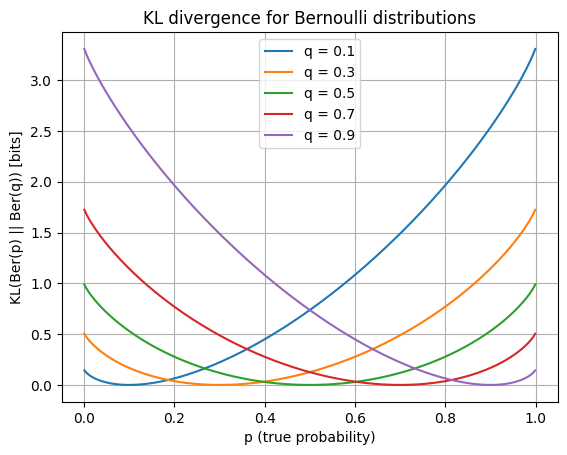

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bernoulli(p: float):
    if not (0.0 <= p <= 1.0):
        raise ValueError("p must be in [0,1]")
    return [p, 1-p]

ps = np.linspace(0.001, 0.999, 200)
q_values = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure()
for q in q_values:
    kl_vals = [kl_divergence(bernoulli(p), bernoulli(q)) for p in ps]
    plt.plot(ps, kl_vals, label=f"q = {q}")

plt.xlabel("p (true probability)")
plt.ylabel("KL(Ber(p) || Ber(q)) [bits]")
plt.title("KL divergence for Bernoulli distributions")
plt.legend()
plt.grid(True)
plt.show()

## 5. Numerical Check: KL is Non-Negative

We can sample random distributions $P$ and $Q$ and check that $\mathrm{KL}(P\Vert Q) \ge 0$.


In [ ]:
import random

def random_distribution(n: int):
    xs = [random.random() for _ in range(n)]
    s = sum(xs)
    return [x / s for x in xs]

for n in [2, 3, 5]:
    print(f"n = {n}")
    for _ in range(5):
        P = random_distribution(n)
        Q = random_distribution(n)
        kl = kl_divergence(P, Q)
        print(f"  KL(P||Q) = {kl:.6f}")
    print()

n = 2
  KL(P||Q) = 0.007434
  KL(P||Q) = 0.100301
  KL(P||Q) = 0.012892
  KL(P||Q) = 0.017884
  KL(P||Q) = 0.004131

n = 3
  KL(P||Q) = 0.666145
  KL(P||Q) = 1.006600
  KL(P||Q) = 0.512109
  KL(P||Q) = 0.514700
  KL(P||Q) = 0.268653

n = 5
  KL(P||Q) = 0.383667
  KL(P||Q) = 0.794642
  KL(P||Q) = 1.262322
  KL(P||Q) = 0.626311
  KL(P||Q) = 0.034249




# KL Divergence: Order Matters (Corrected Demonstration)

This notebook focuses on the point you raised:

> Sometimes a plotted example makes forward and reverse KL look similar.

That can happen because **KL objectives are non-convex** in the parameters of the approximation family. For a symmetric bimodal target and a unimodal Gaussian approximation, **reverse KL has multiple optima**:

- two **global** optima near each mode (mode-seeking)
- one **local** optimum near the center (looks mass-covering)

We'll reproduce this and compute KL values to verify which is truly best.




In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import torch

os.makedirs('vi_kl_assets_v2/figures', exist_ok=True)
plt.rcParams['figure.dpi'] = 120



## 1) Setup: bimodal target p(x) and Gaussian q(x)

Target:
$p(x)=0.5\,\mathcal{N}(-2,0.5^2)+0.5\,\mathcal{N}(2,0.5^2).$
Approximation family:
$q(x)=\mathcal{N}(\mu,\sigma^2).$

We'll optimize:
- forward KL: $\mathrm{KL}(p\|q)=\mathbb{E}_p[\log p-\log q]$
- reverse KL: $\mathrm{KL}(q\|p)=\mathbb{E}_q[\log q-\log p]$


In [ ]:

locs = torch.tensor([-2.0, 2.0])
scale = torch.tensor([0.5, 0.5])


def log_normal(x, mu, sigma):
    return -0.5*torch.log(2*torch.pi*sigma**2) - 0.5*((x-mu)/sigma)**2

def log_p_mixture(x):
    comps = []
    for k in range(2):
        comps.append(log_normal(x, locs[k], scale[k]) + torch.log(torch.tensor(0.5)))
    return torch.logsumexp(torch.stack(comps, dim=0), dim=0)

def log_q_gauss(x, mu, log_sigma):
    return log_normal(x, mu, torch.exp(log_sigma))


def sample_p(S):
    mix = torch.bernoulli(torch.full((S,), 0.5))
    eps = torch.randn(S)
    return torch.where(mix>0, locs[1] + scale[1]*eps, locs[0] + scale[0]*eps)



## 2) Optimization: multiple initializations

Key point: reverse KL is **non-convex** here.
- Starting near the center often yields the **center local optimum**.
- Starting near a mode yields a **mode global optimum**.

We’ll run reverse KL from 3 different initial $\mu$ values.


In [ ]:


def optimize_reverse_kl(mu0=0.0, log_sigma0=0.0, steps=2000, lr=0.03, S=2048, seed=0):
    torch.manual_seed(seed)
    mu = torch.tensor(mu0, requires_grad=True)
    log_sigma = torch.tensor(log_sigma0, requires_grad=True)
    opt = torch.optim.Adam([mu, log_sigma], lr=lr)
    for _ in range(steps):
        eps = torch.randn(S)
        x = mu + torch.exp(log_sigma)*eps
        kl = torch.mean(log_q_gauss(x, mu, log_sigma) - log_p_mixture(x))
        opt.zero_grad(); kl.backward(); opt.step()
    return float(mu.detach()), float(torch.exp(log_sigma.detach())), float(kl.detach())


def optimize_forward_kl(mu0=0.0, log_sigma0=0.0, steps=2000, lr=0.03, S=2048, seed=0):
    torch.manual_seed(seed)
    mu = torch.tensor(mu0, requires_grad=True)
    log_sigma = torch.tensor(log_sigma0, requires_grad=True)
    opt = torch.optim.Adam([mu, log_sigma], lr=lr)
    for _ in range(steps):
        x = sample_p(S)
        kl = torch.mean(log_p_mixture(x) - log_q_gauss(x, mu, log_sigma))
        opt.zero_grad(); kl.backward(); opt.step()
    return float(mu.detach()), float(torch.exp(log_sigma.detach())), float(kl.detach())

rev_center = optimize_reverse_kl(mu0=0.0, log_sigma0=0.0, seed=1)
rev_mode_pos = optimize_reverse_kl(mu0=1.5, log_sigma0=-0.7, seed=2)
rev_mode_neg = optimize_reverse_kl(mu0=-1.5, log_sigma0=-0.7, seed=3)
forw = optimize_forward_kl(mu0=0.0, log_sigma0=0.0, seed=4)

print('Reverse KL from center init  :', rev_center)
print('Reverse KL from +mode init   :', rev_mode_pos)
print('Reverse KL from -mode init   :', rev_mode_neg)
print('Forward KL (any init)        :', forw)


Reverse KL from center init  : (-0.051251303404569626, 1.7684096097946167, 1.8410736322402954)
Reverse KL from +mode init   : (1.9857902526855469, 0.4919416904449463, 0.6928116083145142)
Reverse KL from -mode init   : (-2.008500099182129, 0.49830037355422974, 0.6946550607681274)
Forward KL (any init)        : (-0.01427842490375042, 2.0679216384887695, 0.7377361059188843)



## 3) Plot: forward KL optimum vs reverse KL (global + local)

We plot:
- forward KL solution (mass-covering)
- reverse KL global solutions (mode-seeking)
- reverse KL local solution (center)

Note the KL values: reverse KL globals should be **smaller** than the center local optimum.


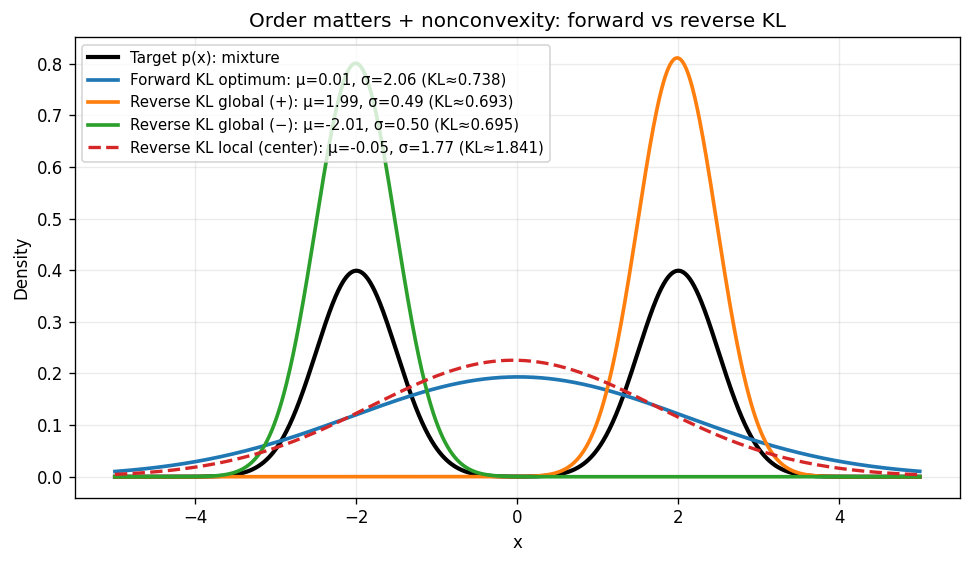

In [ ]:


def normal_pdf(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x-mu)/sigma)**2)

xs = np.linspace(-5, 5, 1000)
p_pdf = 0.5*normal_pdf(xs, -2, 0.5) + 0.5*normal_pdf(xs, 2, 0.5)

plt.figure(figsize=(8.2,4.8))
plt.plot(xs, p_pdf, 'k', lw=2.5, label='Target p(x): mixture')

mu, sig, kl = forw
plt.plot(xs, normal_pdf(xs, mu, sig), lw=2.2, label=f'Forward KL optimum: μ={mu:.2f}, σ={sig:.2f} (KL≈{kl:.3f})')

mu, sig, kl = rev_mode_pos
plt.plot(xs, normal_pdf(xs, mu, sig), lw=2.2, label=f'Reverse KL global (+): μ={mu:.2f}, σ={sig:.2f} (KL≈{kl:.3f})')

mu, sig, kl = rev_mode_neg
plt.plot(xs, normal_pdf(xs, mu, sig), lw=2.2, label=f'Reverse KL global (−): μ={mu:.2f}, σ={sig:.2f} (KL≈{kl:.3f})')

mu, sig, kl = rev_center
plt.plot(xs, normal_pdf(xs, mu, sig), lw=2.0, linestyle='--', label=f'Reverse KL local (center): μ={mu:.2f}, σ={sig:.2f} (KL≈{kl:.3f})')

plt.title('Order matters + nonconvexity: forward vs reverse KL')
plt.xlabel('x'); plt.ylabel('Density')
plt.grid(True, alpha=0.25)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig('vi_kl_assets_v2/figures/forward_reverse_corrected.png')
plt.show()


In [ ]:
forw

(0.011748585850000381, 2.064044713973999, 0.7377064824104309)


## 4) Numerical check: compare KL values of candidate solutions

This confirms the main point:
- reverse KL **prefers a mode** (lower KL)
- the center solution is **only a local optimum**


In [ ]:

# Monte Carlo estimates of true KL values for the found solutions

rng = np.random.default_rng(0)

def log_p_np(x):
    a = np.log(0.5) + np.log(normal_pdf(x, -2, 0.5) + 1e-300)
    b = np.log(0.5) + np.log(normal_pdf(x,  2, 0.5) + 1e-300)
    m = np.maximum(a,b)
    return m + np.log(np.exp(a-m)+np.exp(b-m))

def log_q_np(x, mu, sig):
    return np.log(normal_pdf(x, mu, sig) + 1e-300)

def sample_p_np(S):
    mix = rng.random(S) < 0.5
    eps = rng.standard_normal(S)
    return np.where(mix, -2 + 0.5*eps, 2 + 0.5*eps)

def sample_q_np(S, mu, sig):
    return mu + sig*rng.standard_normal(S)

def kl_forward_np(mu, sig, S=200000):
    x = sample_p_np(S)
    return float(np.mean(log_p_np(x) - log_q_np(x, mu, sig)))

def kl_reverse_np(mu, sig, S=200000):
    x = sample_q_np(S, mu, sig)
    return float(np.mean(log_q_np(x, mu, sig) - log_p_np(x)))

cands = {
    'forward_opt': (forw[0], forw[1]),
    'reverse_global_plus': (rev_mode_pos[0], rev_mode_pos[1]),
    'reverse_global_minus': (rev_mode_neg[0], rev_mode_neg[1]),
    'reverse_local_center': (rev_center[0], rev_center[1]),
}

for name, (mu, sig) in cands.items():
    kf = kl_forward_np(mu, sig, S=120000)
    kr = kl_reverse_np(mu, sig, S=120000)
    print(f'{name:20s}  KL(p||q)≈{kf:8.3f}   KL(q||p)≈{kr:8.3f}')


forward_opt           KL(p||q)≈   0.722   KL(q||p)≈   2.108
reverse_global_plus   KL(p||q)≈  15.679   KL(q||p)≈   0.694
reverse_global_minus  KL(p||q)≈  15.413   KL(q||p)≈   0.693
reverse_local_center  KL(p||q)≈   0.752   KL(q||p)≈   1.887


In [ ]:
# Edit P and Q below
P = [0.7, 0.2, 0.1]
Q = [0.6, 0.25, 0.15]

print("P =", P)
print("Q =", Q)
print("H(P)       =", entropy(P), "bits")
print("H(P, Q)    =", cross_entropy(P, Q), "bits")
print("KL(P || Q) =", kl_divergence(P, Q), "bits")

P = [0.7, 0.2, 0.1]
Q = [0.6, 0.25, 0.15]
H(P)       = 1.1567796494470395 bits
H(P, Q)    = 1.189572475332965 bits
KL(P || Q) = 0.032792825885925546 bits



# Variational Distributions and Mean-Field Approximation

This notebook accompanies the slides. It provides:

- What a variational distribution $q(z)$ is and why we choose a tractable family
- Derivation of the ELBO using **Jensen's inequality**
- Mean-field factorization $q(z)=\prod_i q_i(z_i)$ and coordinate ascent intuition
- A 2D Gaussian example showing what mean-field cannot represent (correlations)

Figures are saved into `vi_mean_field_assets/figures/` for LaTeX inclusion.


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('vi_mean_field_assets/figures', exist_ok=True)
plt.rcParams['figure.dpi'] = 120



## 1) Jensen's inequality (why we get a lower bound)

Because $\log$ is concave:
$ \log(\mathbb{E}[X]) \ge \mathbb{E}[\log X]. $

This is the key step in deriving the ELBO.


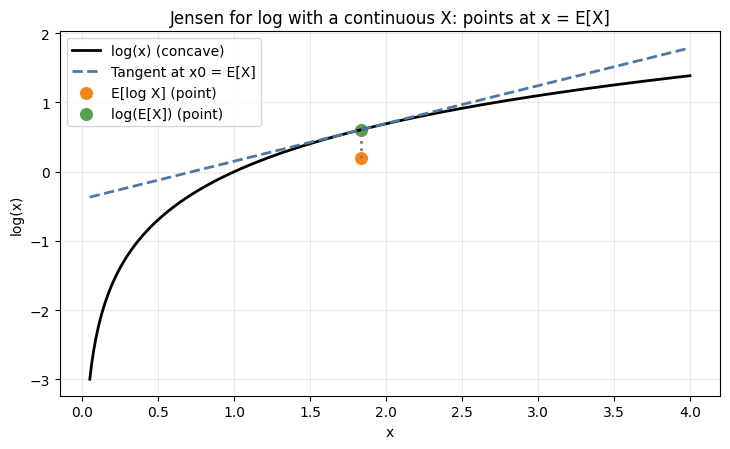

E[X]       = 1.8329274797875807
E[log X]   = 0.20011760799737363
log(E[X])  = 0.6059144044020087
gap        = 0.40579679640463506


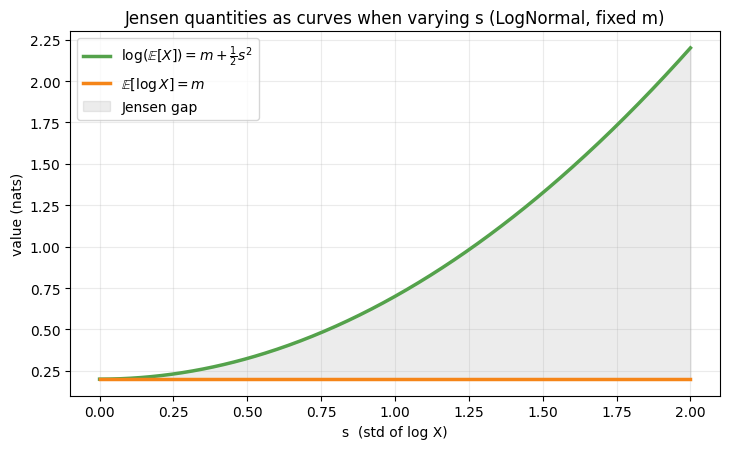

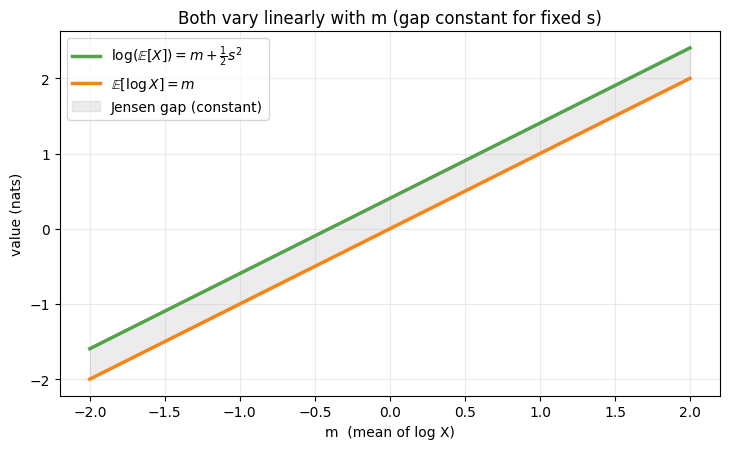

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Non-2-point distribution ----------
# X ~ LogNormal(m, s^2), continuous on (0, infinity)
rng = np.random.default_rng(0)
m = 0.2
s = 0.9
N = 200_000

X = rng.lognormal(mean=m, sigma=s, size=N)

Ex = X.mean()
Elog = np.log(X).mean()
logE = np.log(Ex)

# ---------- Plot 1: show them as points (fixed distribution) ----------
xgrid = np.linspace(0.05, 4.0, 600)
ygrid = np.log(xgrid)

# Tangent at x0 = E[X] (universal Jensen picture for concave log)
tangent = np.log(Ex) + (1/Ex) * (xgrid - Ex)

plt.figure(figsize=(7.4, 4.6))
plt.plot(xgrid, ygrid, color='black', lw=2, label='log(x) (concave)')
plt.plot(xgrid, tangent, color='#4C78A8', lw=2, linestyle='--',
         label='Tangent at x0 = E[X]')
plt.scatter([Ex], [Elog], color='#F58518', s=70, label='E[log X] (point)')
plt.scatter([Ex], [logE], color='#54A24B', s=70, label='log(E[X]) (point)')
plt.vlines(Ex, Elog, logE, color='gray', linestyle=':', lw=2)

plt.title('Jensen for log with a continuous X: points at x = E[X]')
plt.xlabel('x')
plt.ylabel('log(x)')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

print("E[X]       =", Ex)
print("E[log X]   =", Elog)
print("log(E[X])  =", logE)
print("gap        =", logE - Elog)

# ---------- Plot 2: treat them as curves by varying s (distribution changes) ----------
s_grid = np.linspace(0.0, 2.0, 401)
Elog_curve = np.full_like(s_grid, m)          # E[log X] = m
logE_curve = m + 0.5 * s_grid**2              # log(E[X]) = m + s^2/2

plt.figure(figsize=(7.4, 4.6))
plt.plot(s_grid, logE_curve, lw=2.5, color='#54A24B',
         label=r'$\log(\mathbb{E}[X]) = m + \frac{1}{2}s^2$')
plt.plot(s_grid, Elog_curve, lw=2.5, color='#F58518',
         label=r'$\mathbb{E}[\log X] = m$')
plt.fill_between(s_grid, Elog_curve, logE_curve, color='gray', alpha=0.15,
                 label='Jensen gap')

plt.title('Jensen quantities as curves when varying s (LogNormal, fixed m)')
plt.xlabel('s  (std of log X)')
plt.ylabel('value (nats)')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot 3 (optional): curves vs m with fixed s ----------
m_grid = np.linspace(-2, 2, 401)
Elog_m = m_grid
logE_m = m_grid + 0.5 * s**2

plt.figure(figsize=(7.4, 4.6))
plt.plot(m_grid, logE_m, lw=2.5, color='#54A24B',
         label=r'$\log(\mathbb{E}[X]) = m + \frac{1}{2}s^2$')
plt.plot(m_grid, Elog_m, lw=2.5, color='#F58518',
         label=r'$\mathbb{E}[\log X] = m$')
plt.fill_between(m_grid, Elog_m, logE_m, color='gray', alpha=0.15,
                 label='Jensen gap (constant)')

plt.title('Both vary linearly with m (gap constant for fixed s)')
plt.xlabel('m  (mean of log X)')
plt.ylabel('value (nats)')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


## 2) ELBO derivation (symbolic steps)

Start:
$\log p(x)=\log\int p(x,z)dz.$

Insert any $q(z)$:
$\log p(x)=\log\int q(z)\frac{p(x,z)}{q(z)}dz = \log\mathbb{E}_q\left[\frac{p(x,z)}{q(z)}\right].$

Apply Jensen:
$\log p(x) \ge \mathbb{E}_q[\log p(x,z) - \log q(z)] \equiv \mathcal{L}(q).$

The gap is:
$\log p(x)-\mathcal{L}(q)=\mathrm{KL}(q(z)\|p(z\mid x)).$



## 3) Mean-field approximation

Mean-field assumes independence:
$ q(z)=\prod_{i=1}^m q_i(z_i). $

Why it matters:
- breaks high-dimensional expectations into smaller ones
- leads to coordinate ascent updates in conjugate models

Coordinate ascent update:
$ \log q_i^*(z_i)=\mathbb{E}_{q_{-i}}[\log p(x,z)] + \text{const}. $



## 4) Example: correlated Gaussian posterior vs mean-field

Let the true posterior be a correlated 2D Gaussian:
$p(z)=\mathcal{N}(0,\Sigma),\quad \Sigma=\begin{pmatrix}1 & \rho\sigma_1\sigma_2\\ \rho\sigma_1\sigma_2 & \sigma_2^2\end{pmatrix}.
$

Mean-field Gaussian restricts covariance to diagonal:
$q(z)=\mathcal{N}(0,\mathrm{diag}(\sigma_1^2,\sigma_2^2)).$

We plot contours to see what mean-field cannot represent.


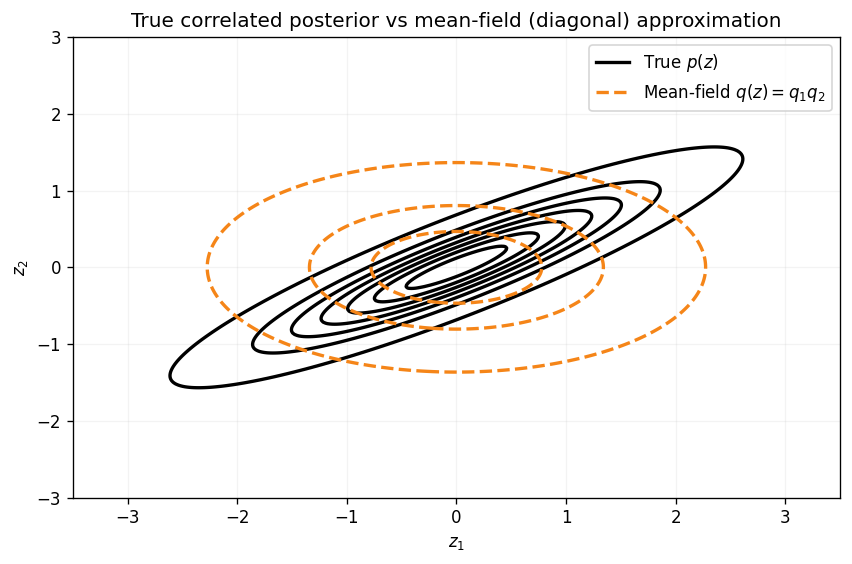

In [ ]:

mu = np.array([0.0, 0.0])
rho = 0.9
sig1, sig2 = 1.0, 0.6
Sigma = np.array([[sig1**2, rho*sig1*sig2], [rho*sig1*sig2, sig2**2]])
Sigma_q = np.diag([sig1**2, sig2**2])

xx = np.linspace(-3.5, 3.5, 350)
yy = np.linspace(-3.0, 3.0, 300)
X, Y = np.meshgrid(xx, yy)
Pos = np.dstack((X, Y))

def gaussian_pdf(pos, mean, cov):
    inv = np.linalg.inv(cov)
    det = np.linalg.det(cov)
    diff = pos - mean
    expo = np.einsum('...i,ij,...j->...', diff, inv, diff)
    return np.exp(-0.5*expo)/np.sqrt((2*np.pi)**2 * det)

P = gaussian_pdf(Pos, mu, Sigma)
Q = gaussian_pdf(Pos, mu, Sigma_q)
levels = np.linspace(0.02, P.max()*0.9, 7)

plt.figure(figsize=(7.2,4.8))
plt.contour(X, Y, P, levels=levels, colors='black', linewidths=2)
plt.contour(X, Y, Q, levels=levels, colors='#F58518', linestyles='--', linewidths=2)
plt.title('True correlated posterior vs mean-field (diagonal) approximation')
plt.xlabel('$z_1$'); plt.ylabel('$z_2$')
plt.grid(True, alpha=0.15)
plt.legend(handles=[
    plt.Line2D([0],[0], color='black', lw=2, label='True $p(z)$'),
    plt.Line2D([0],[0], color='#F58518', lw=2, linestyle='--', label='Mean-field $q(z)=q_1q_2$')
], loc='upper right')
plt.tight_layout()
plt.savefig('vi_mean_field_assets/figures/gaussian_contours_meanfield.png')
plt.show()


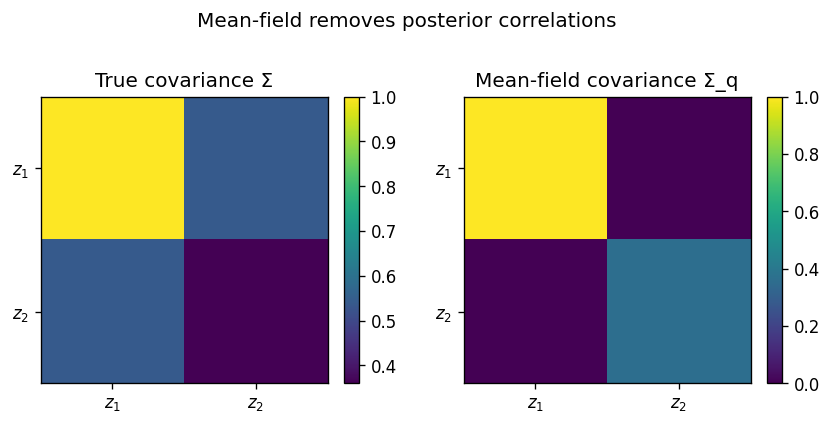

In [ ]:

# Covariance heatmaps
plt.figure(figsize=(7.2,3.4))
plt.subplot(1,2,1)
plt.imshow(Sigma, cmap='viridis')
plt.colorbar(fraction=0.046)
plt.title('True covariance Σ')
plt.xticks([0,1], ['$z_1$','$z_2$'])
plt.yticks([0,1], ['$z_1$','$z_2$'])

plt.subplot(1,2,2)
plt.imshow(Sigma_q, cmap='viridis')
plt.colorbar(fraction=0.046)
plt.title('Mean-field covariance Σ_q')
plt.xticks([0,1], ['$z_1$','$z_2$'])
plt.yticks([0,1], ['$z_1$','$z_2$'])

plt.suptitle('Mean-field removes posterior correlations')
plt.tight_layout(rect=[0,0,1,0.92])
plt.savefig('vi_mean_field_assets/figures/covariance_heatmaps.png')
plt.show()



## 5) Quantify the approximation error: KL(q||p)

For Gaussians with equal means:
$\mathrm{KL}(\mathcal{N}(0,\Sigma_q)\|\mathcal{N}(0,\Sigma))
=\tfrac12\Big(\mathrm{tr}(\Sigma^{-1}\Sigma_q)-k + \log\tfrac{\det\Sigma}{\det\Sigma_q}\Big).$

We compare:
- full-covariance Gaussian (can match exactly → KL=0)
- mean-field diagonal Gaussian
- diagonal but too-narrow Gaussian (collapsed)


KL(full||true)= 0.0
KL(mean-field||true)= 3.4327922913260194
KL(narrow diag||true)= 1.0622927783977945


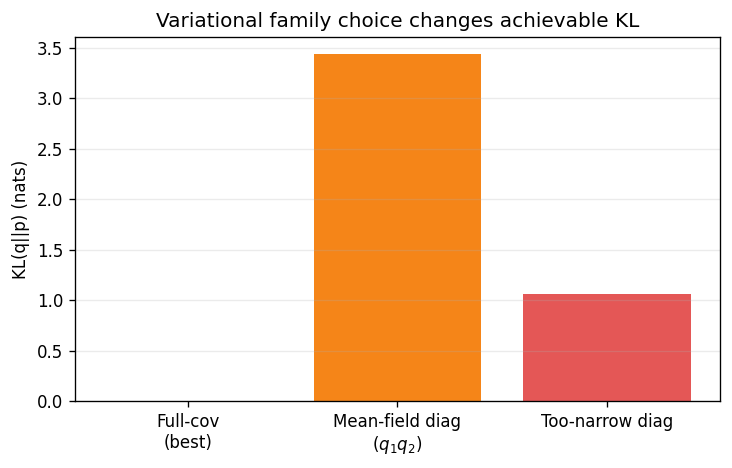

In [ ]:

def kl_gauss(Sq, S):
    k = S.shape[0]
    invS = np.linalg.inv(S)
    return 0.5*(np.trace(invS@Sq) - k + np.log(np.linalg.det(S)/np.linalg.det(Sq)))

Sigma_q_mf = Sigma_q
Sigma_q_full = Sigma
Sigma_q_narrow = np.diag([0.6**2, 0.35**2])

kl_full = kl_gauss(Sigma_q_full, Sigma)
kl_mf = kl_gauss(Sigma_q_mf, Sigma)
kl_narrow = kl_gauss(Sigma_q_narrow, Sigma)

print('KL(full||true)=', kl_full)
print('KL(mean-field||true)=', kl_mf)
print('KL(narrow diag||true)=', kl_narrow)

plt.figure(figsize=(6.2,4))
vals = [kl_full, kl_mf, kl_narrow]
labels = ['Full-cov\n(best)', 'Mean-field diag\n($q_1q_2$)', 'Too-narrow diag']
colors = ['#54A24B', '#F58518', '#E45756']
plt.bar(range(len(vals)), vals, color=colors)
plt.xticks(range(len(vals)), labels)
plt.ylabel('KL(q||p) (nats)')
plt.title('Variational family choice changes achievable KL')
plt.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.savefig('vi_mean_field_assets/figures/kl_bar_variational_family.png')
plt.show()


# ELBO: The Heart of Variational Inference

This notebook provides:

1. A clean derivation of the ELBO starting from
   $\mathrm{KL}(q(z)\|p(z\mid x))$.
2. The key identity:
   $\mathrm{KL}(q\|p(z\mid x)) = \log p(x) - \mathcal{L}(q).$
3. The standard ELBO decomposition:
   $\mathcal{L}(q)=\mathbb{E}_q[\log p(x\mid z)]-\mathrm{KL}(q(z)\|p(z)).$
4. A fully worked 1D Gaussian latent-variable example with analytic formulas and plots.

Figures are saved to `vi_elbo_assets/figures/`.


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('vi_elbo_assets/figures', exist_ok=True)
plt.rcParams['figure.dpi'] = 120


## 1) Deriving the ELBO from KL(q‖posterior)

Start:  
$ \mathrm{KL}(q(z)\|p(z\mid x)) = \mathbb{E}_q[\log q(z) - \log p(z\mid x)] $.

Use Bayes:  
$ \log p(z\mid x) = \log p(x,z) - \log p(x) $.

Then:  
$ \mathrm{KL}(q\|p(z\mid x)) = \log p(x) - \mathbb{E}_q[\log p(x,z) - \log q(z)] $.

Define ELBO:  
$ \mathcal{L}(q) = \mathbb{E}_q[\log p(x,z)] - \mathbb{E}_q[\log q(z)] $.

So:  
$ \mathrm{KL}(q\|p(z\mid x)) = \log p(x) - \mathcal{L}(q) $.



## 2) ELBO interpretation

For latent models $ p(x,z) = p(x\mid z)p(z) $:

$ \mathcal{L}(q) = \mathbb{E}_q[\log p(x\mid z)] - \mathrm{KL}(q(z)\|p(z)) $.

- $ \mathbb{E}_q[\log p(x\mid z)] $: **accuracy / reconstruction**
- $ \mathrm{KL}(q\|p(z)) $: **complexity** penalty for deviating from the prior



## 3) Worked example: conjugate Gaussian model

Model:
- Prior: $ z \sim \mathcal{N}(0,1) $
- Likelihood: $ x \mid z \sim \mathcal{N}(z,\sigma_x^2) $

Variational family:
- $ q(z) = \mathcal{N}(\mu,\sigma^2) $

Because the model is conjugate, the true posterior is Gaussian and we can compute:
- $ \log p(x) $ exactly
- ELBO exactly
- $ \mathrm{KL}(q\|p(z\mid x)) $ exactly

We then verify numerically that:
$ \log p(x) - \mathcal{L}(q) = \mathrm{KL}(q\|p(z\mid x)) $.

In [ ]:

# Observed data and noise
x_obs = 1.5
sigma_x = 0.7

# True posterior parameters
post_var = 1 / (1 + 1/(sigma_x**2))
post_mean = post_var * (x_obs/(sigma_x**2))
post_std = np.sqrt(post_var)

# Evidence p(x) = N(0, 1+sigma_x^2)
log_px = -0.5*np.log(2*np.pi*(1+sigma_x**2)) - 0.5*(x_obs**2)/(1+sigma_x**2)

print('Posterior mean:', post_mean)
print('Posterior std :', post_std)
print('log p(x)      :', log_px)


Posterior mean: 1.0067114093959733
Posterior std : 0.5734623443633283
log p(x)      : -1.8733601502303365


In [ ]:

# ELBO and KL formulas

def elbo(mu, s):
    # ELBO = E_q[log p(x|z)] - KL(q||p(z))
    recon = -0.5*np.log(2*np.pi*(sigma_x**2)) - 0.5*((x_obs-mu)**2 + s**2)/(sigma_x**2)
    kl_q_prior = 0.5*(mu**2 + s**2 - 1 - np.log(s**2))
    return recon - kl_q_prior, recon, kl_q_prior

def kl_q_posterior(mu, s):
    return 0.5*( (s**2)/post_var + ((mu-post_mean)**2)/post_var - 1 + np.log(post_var/(s**2)) )

# Check the identity at a random q
mu_test, s_test = 0.2, 1.1
L, recon, klprior = elbo(mu_test, s_test)
klpost = kl_q_posterior(mu_test, s_test)

print('log p(x) - ELBO    =', log_px - L)
print('KL(q||posterior)   =', klpost)
print('difference         =', (log_px - L) - klpost)


log p(x) - ELBO    = 1.6777769327006675
KL(q||posterior)   = 1.6777769327006675
difference         = 0.0


/tmp/ipython-input-698515933.py:14: UserWarning: Glyph 120027 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL L}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-698515933.py:15: UserWarning: Glyph 120027 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL L}) missing from font(s) DejaVu Sans.
  plt.savefig('vi_elbo_assets/figures/elbo_vs_mu.png')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120027 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL L}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


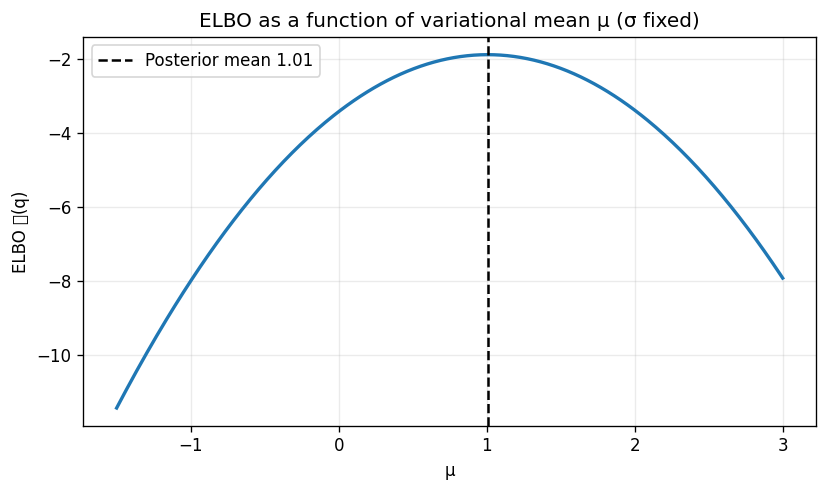

In [ ]:

# Plot 1: ELBO vs mu (sigma fixed)
s_fixed = post_std
mu_grid = np.linspace(-1.5, 3.0, 400)
L_mu = np.array([elbo(m, s_fixed)[0] for m in mu_grid])

plt.figure(figsize=(7.0,4.2))
plt.plot(mu_grid, L_mu, lw=2)
plt.axvline(post_mean, color='k', linestyle='--', label=f'Posterior mean {post_mean:.2f}')
plt.title('ELBO as a function of variational mean μ (σ fixed)')
plt.xlabel('μ')
plt.ylabel('ELBO 𝓛(q)')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_elbo_assets/figures/elbo_vs_mu.png')
plt.show()


/tmp/ipython-input-2601166058.py:14: UserWarning: Glyph 120027 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL L}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2601166058.py:15: UserWarning: Glyph 120027 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL L}) missing from font(s) DejaVu Sans.
  plt.savefig('vi_elbo_assets/figures/elbo_vs_sigma.png')


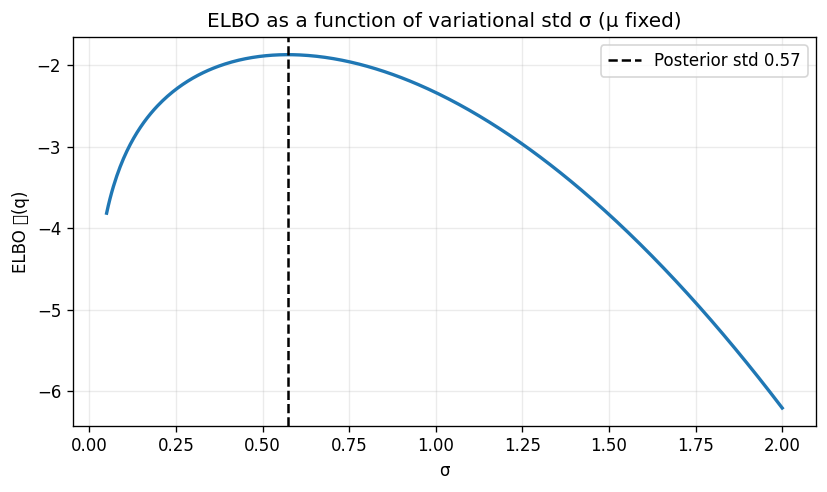

In [ ]:

# Plot 2: ELBO vs sigma (mu fixed)
mu_fixed = post_mean
s_grid = np.linspace(0.05, 2.0, 400)
L_s = np.array([elbo(mu_fixed, s)[0] for s in s_grid])

plt.figure(figsize=(7.0,4.2))
plt.plot(s_grid, L_s, lw=2)
plt.axvline(post_std, color='k', linestyle='--', label=f'Posterior std {post_std:.2f}')
plt.title('ELBO as a function of variational std σ (μ fixed)')
plt.xlabel('σ')
plt.ylabel('ELBO 𝓛(q)')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_elbo_assets/figures/elbo_vs_sigma.png')
plt.show()


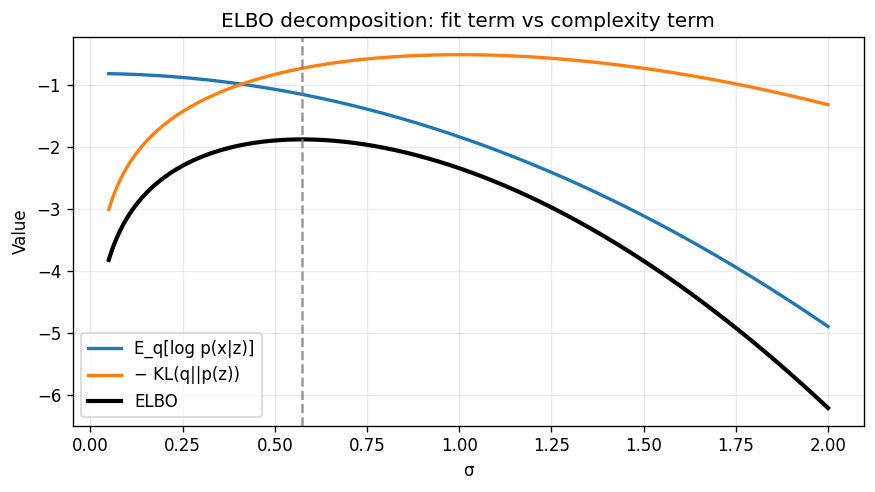

In [ ]:

# Plot 3: ELBO decomposition: recon vs -KL to prior
recon_s = np.array([elbo(mu_fixed, s)[1] for s in s_grid])
klprior_s = np.array([elbo(mu_fixed, s)[2] for s in s_grid])

plt.figure(figsize=(7.4,4.2))
plt.plot(s_grid, recon_s, lw=2, label='E_q[log p(x|z)]')
plt.plot(s_grid, -klprior_s, lw=2, label='− KL(q||p(z))')
plt.plot(s_grid, recon_s - klprior_s, lw=2.5, label='ELBO', color='black')
plt.axvline(post_std, color='gray', linestyle='--', alpha=0.8)
plt.title('ELBO decomposition: fit term vs complexity term')
plt.xlabel('σ')
plt.ylabel('Value')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_elbo_assets/figures/elbo_decomposition.png')
plt.show()


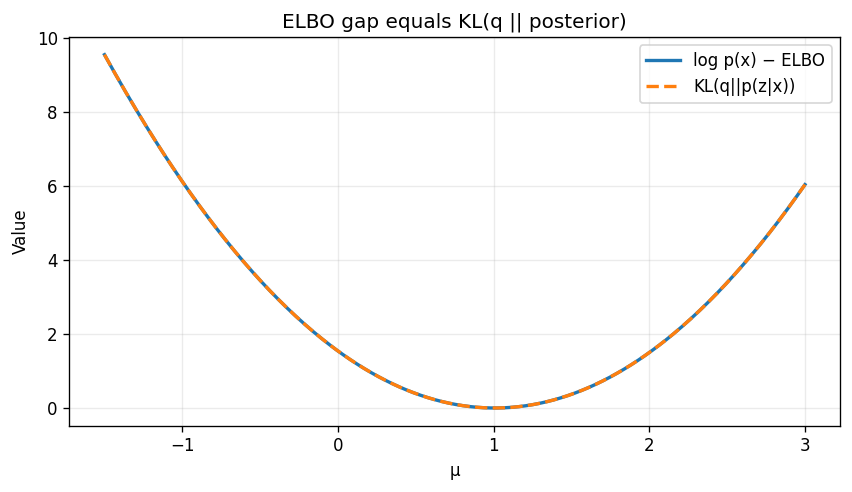

In [ ]:

# Plot 4: ELBO gap equals KL(q||posterior)
KL_post_mu = np.array([kl_q_posterior(m, s_fixed) for m in mu_grid])
Gap_mu = log_px - L_mu

plt.figure(figsize=(7.2,4.2))
plt.plot(mu_grid, Gap_mu, lw=2, label='log p(x) − ELBO')
plt.plot(mu_grid, KL_post_mu, lw=2, linestyle='--', label='KL(q||p(z|x))')
plt.title('ELBO gap equals KL(q || posterior)')
plt.xlabel('μ')
plt.ylabel('Value')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_elbo_assets/figures/elbo_gap_equals_kl.png')
plt.show()


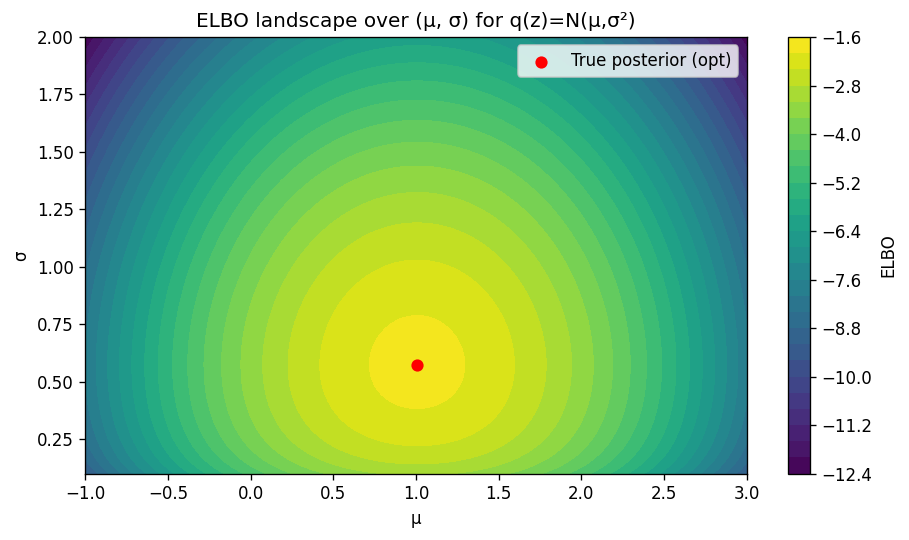

In [ ]:

# Plot 5: ELBO surface over (mu, sigma)
MU, SG = np.meshgrid(np.linspace(-1.0, 3.0, 140), np.linspace(0.1, 2.0, 140))
L_surf = np.zeros_like(MU)
for i in range(MU.shape[0]):
    for j in range(MU.shape[1]):
        L_surf[i,j] = elbo(MU[i,j], SG[i,j])[0]

plt.figure(figsize=(7.8,4.6))
cs = plt.contourf(MU, SG, L_surf, levels=30, cmap='viridis')
plt.colorbar(cs, label='ELBO')
plt.scatter([post_mean], [post_std], color='red', s=40, label='True posterior (opt)')
plt.title('ELBO landscape over (μ, σ) for q(z)=N(μ,σ²)')
plt.xlabel('μ')
plt.ylabel('σ')
plt.legend()
plt.tight_layout()
plt.savefig('vi_elbo_assets/figures/elbo_surface.png')
plt.show()



# Stochastic Variational Inference (SVI)

This notebook provides a hands-on introduction to **SVI** (stochastic variational inference), focusing on:

- **Minibatch estimates** of the ELBO (and its gradients)
- **Natural-gradient** style updates (common in conjugate exponential-family models)
- **Online learning** (streaming data)

We use a simple conjugate model where the true posterior is known, so we can validate that SVI converges to the correct answer.

Figures are saved to `vi_svi_assets/figures/`.


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('vi_svi_assets/figures', exist_ok=True)
plt.rcParams['figure.dpi'] = 120



## 1) Setup

Model:
$\theta \sim \mathcal{N}(\mu_0, \lambda_0^{-1}),\qquad x_n\mid\theta \sim \mathcal{N}(\theta,\sigma^2).$

Variational family:
$q(\theta)=\mathcal{N}(\mu,\lambda^{-1}).$

Key idea: for large $N$, we cannot sum over all data each iteration, so we use minibatches.


In [ ]:

rng = np.random.default_rng(0)
N = 20000
true_theta = 1.0
sigma = 1.0
x = rng.normal(true_theta, sigma, size=N)

mu0 = 0.0
lambda0 = 1.0

# Exact posterior (for validation)
post_lambda = lambda0 + N/(sigma**2)
post_mu = (lambda0*mu0 + np.sum(x)/(sigma**2)) / post_lambda
post_var = 1/post_lambda

print('Posterior mean:', post_mu)
print('Posterior var :', post_var)


Posterior mean: 1.0046312068824894
Posterior var : 4.999750012499375e-05



## 2) Minibatch scaling

The ELBO contains a sum over data. With minibatch $\mathcal{B}$ (size $B$):
$\sum_{n=1}^N f(x_n) \approx \frac{N}{B}\sum_{b\in\mathcal{B}} f(x_b).$

This makes the gradient estimate noisy but cheap.



## 3) Natural-gradient style SVI update

In conjugate exponential-family models, the update often looks like an exponential moving average:
$\lambda_t \leftarrow (1-\rho_t)\lambda_{t-1} + \rho_t\,\hat\lambda_t,$
where $\hat\lambda_t$ is computed from a minibatch and $\rho_t$ is a decreasing step size.

Below we implement SVI for this toy model.


In [ ]:


def svi_run(x, N, batch_size=200, iters=400, tau=50, kappa=0.7, seed=1, streaming=False):
    r = np.random.default_rng(seed)
    mu, lam = 0.0, 1.0
    mus=[mu]; lams=[lam]; rhos=[]

    if streaming:
        stream_theta = np.linspace(0.0, 2.0, iters)

    for t in range(1, iters+1):
        rho_t = (t + tau)**(-kappa)
        rhos.append(rho_t)

        if not streaming:
            idx = r.choice(N, size=batch_size, replace=False)
            xb = x[idx]
        else:
            th = stream_theta[t-1]
            xb = r.normal(th, sigma, size=batch_size)

        sum_xb = np.sum(xb)

        # Target natural parameters (scaled minibatch sufficient stats)
        lam_hat = lambda0 + N/(sigma**2)
        eta1_hat = lambda0*mu0 + (N/batch_size)*sum_xb/(sigma**2)

        # Natural-parameter EMA update
        eta1 = lam*mu
        eta1 = (1-rho_t)*eta1 + rho_t*eta1_hat
        lam  = (1-rho_t)*lam  + rho_t*lam_hat
        mu = eta1/lam

        mus.append(mu); lams.append(lam)

    return np.array(mus), np.array(lams), np.array(rhos)

mus, lams, rhos = svi_run(x, N, batch_size=200, iters=400, seed=2)


## Graph 1: Convergence (mean and variance)

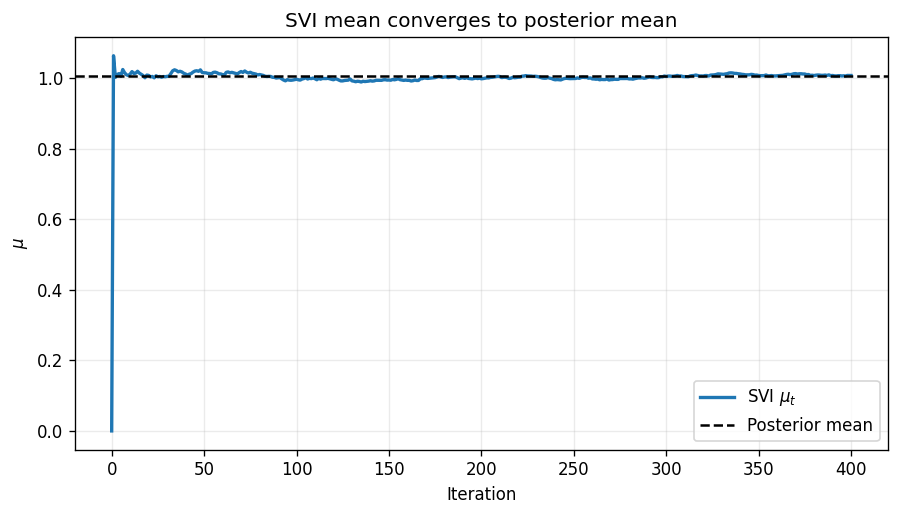

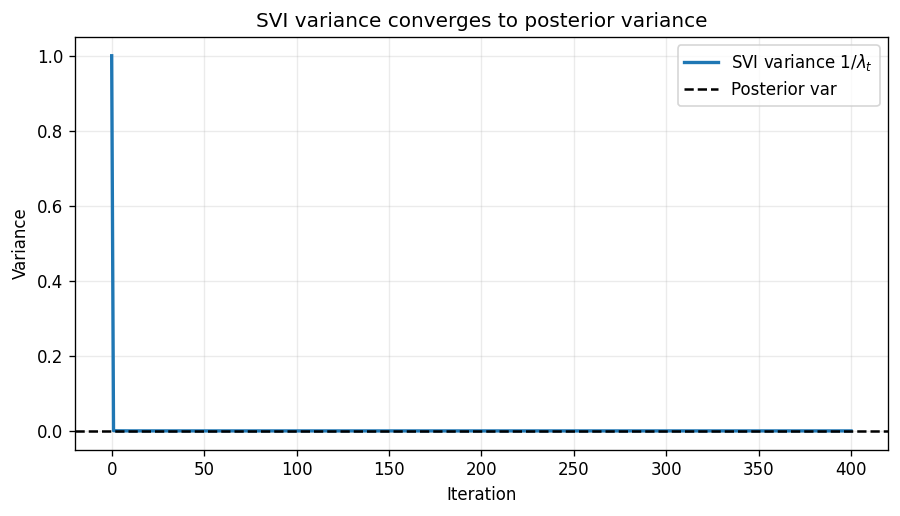

In [ ]:

plt.figure(figsize=(7.6,4.4))
plt.plot(mus, label=r'SVI $\mu_t$', lw=2)
plt.axhline(post_mu, color='k', linestyle='--', label='Posterior mean')
plt.title('SVI mean converges to posterior mean')
plt.xlabel('Iteration')
plt.ylabel(r'$\mu$')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_svi_assets/figures/svi_mu_convergence.png')
plt.show()

plt.figure(figsize=(7.6,4.4))
plt.plot(1/lams, label=r'SVI variance $1/\lambda_t$', lw=2)
plt.axhline(post_var, color='k', linestyle='--', label='Posterior var')
plt.title('SVI variance converges to posterior variance')
plt.xlabel('Iteration')
plt.ylabel('Variance')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_svi_assets/figures/svi_var_convergence.png')
plt.show()


## Graph 2: Step-size schedule

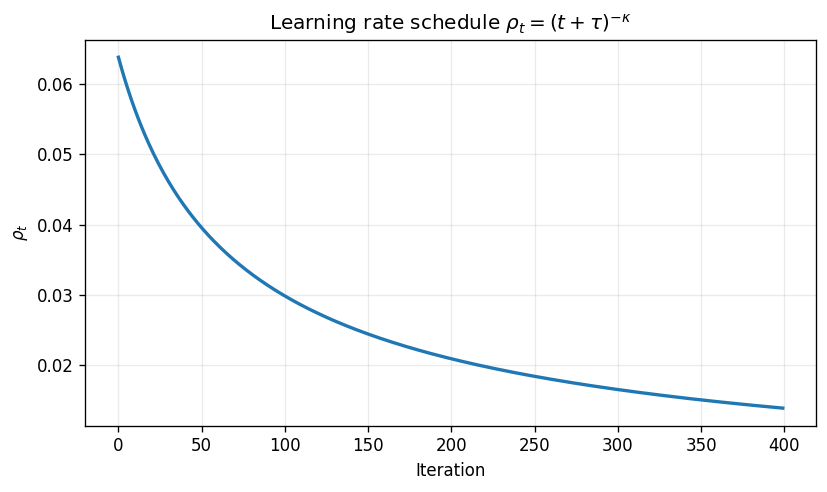

In [ ]:

plt.figure(figsize=(7.0,4.2))
plt.plot(rhos, lw=2)
plt.title(r'Learning rate schedule $\rho_t=(t+\tau)^{-\kappa}$')
plt.xlabel('Iteration')
plt.ylabel(r'$\rho_t$')
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig('vi_svi_assets/figures/svi_rho_schedule.png')
plt.show()


## Graph 3: Minibatch noise vs batch size

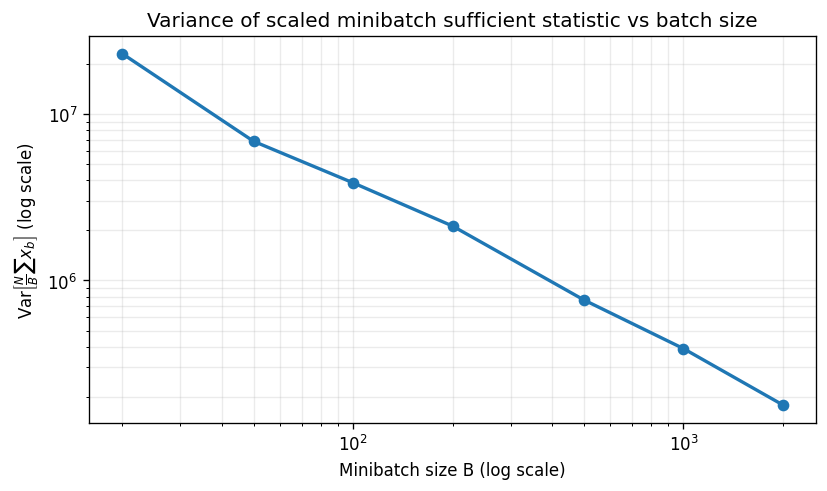

In [ ]:

batch_sizes = np.array([20, 50, 100, 200, 500, 1000, 2000])
R = 300
vars_est=[]
for B in batch_sizes:
    ests=[]
    for _ in range(R):
        idx = rng.choice(N, size=B, replace=False)
        ests.append((N/B)*np.sum(x[idx]))
    vars_est.append(np.var(ests))
vars_est = np.array(vars_est)

plt.figure(figsize=(7.0,4.2))
plt.loglog(batch_sizes, vars_est, marker='o', lw=2)
plt.title('Variance of scaled minibatch sufficient statistic vs batch size')
plt.xlabel('Minibatch size B (log scale)')
plt.ylabel(r'Var$\left[\frac{N}{B}\sum x_b\right]$ (log scale)')
plt.grid(True, which='both', alpha=0.25)
plt.tight_layout()
plt.savefig('vi_svi_assets/figures/svi_minibatch_variance.png')
plt.show()


## Graph 4: Online learning (drifting mean)

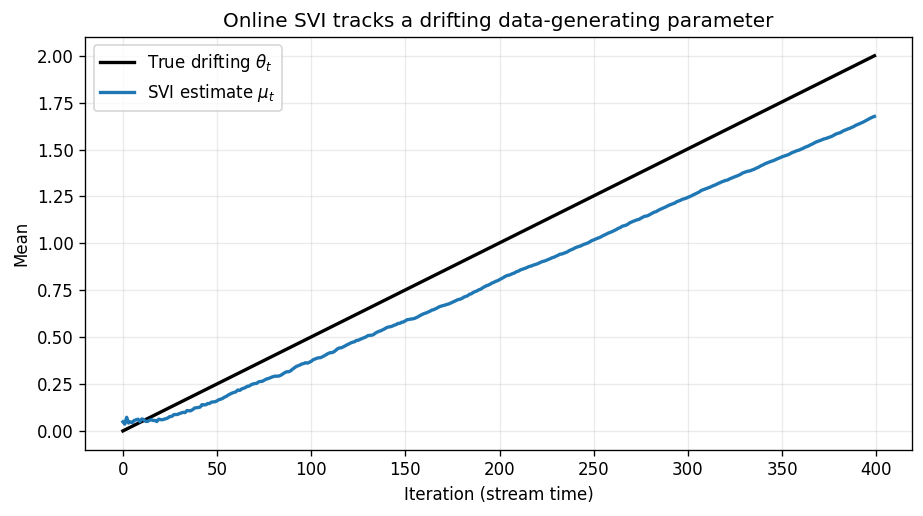

In [ ]:

stream_mus, stream_lams, stream_rhos = svi_run(x, N, batch_size=200, iters=400, seed=3, streaming=True)
stream_theta = np.linspace(0.0, 2.0, 400)

plt.figure(figsize=(7.8,4.4))
plt.plot(stream_theta, label=r'True drifting $\theta_t$', color='black', lw=2)
plt.plot(stream_mus[1:], label=r'SVI estimate $\mu_t$', lw=2)
plt.title('Online SVI tracks a drifting data-generating parameter')
plt.xlabel('Iteration (stream time)')
plt.ylabel('Mean')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_svi_assets/figures/svi_online_tracking.png')
plt.show()



# Reparameterization Trick and REINFORCE (Score-function Estimator)

This notebook supports the slides and provides:

- Theory + intuition for **reparameterization**: $z=\mu+\sigma\epsilon$
- Theory + intuition for **REINFORCE**: $\mathbb{E}[f(z)\nabla\log q(z)]$
- Why REINFORCE can have high variance and how **baselines/control variates** help
- Empirical variance comparisons with graphs

All figures are saved to `vi_reparam_assets/figures/`.


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('vi_reparam_assets/figures', exist_ok=True)
plt.rcParams['figure.dpi'] = 120


## Continuous toy objective: full derivations

### Objective
Let
$
J(\mu)=\mathbb{E}_{z\sim\mathcal N(\mu,1)}\big[(z-3)^2\big].
$
Define
$
f(z) := (z-3)^2,\qquad p_\mu(z):=\mathcal N(z;\mu,1).
$

---

## 1) Closed-form expression for $J(\mu)$ and its gradient

### Step 1: Rewrite $z$ as a shift of a standard normal
Let
$
z=\mu+\eta,\qquad \eta\sim\mathcal N(0,1).
$
Then
$
J(\mu)=\mathbb{E}_{\eta\sim\mathcal N(0,1)}\big[(\mu+\eta-3)^2\big].
$

### Step 2: Expand the square
$
(\mu+\eta-3)^2 = (\mu-3)^2 + 2(\mu-3)\eta + \eta^2.
$

### Step 3: Take expectations using $\mathbb{E}[\eta]=0$ and $\mathbb{E}[\eta^2]=1$
$
J(\mu) = (\mu-3)^2 + 2(\mu-3)\mathbb{E}[\eta] + \mathbb{E}[\eta^2]
       = (\mu-3)^2 + 1.
$

### Step 4: Differentiate
$
\nabla_\mu J(\mu)=\frac{d}{d\mu}\big((\mu-3)^2+1\big)=2(\mu-3).
$

---

## 2) Reparameterization (pathwise) gradient estimator

### Step 1: Reparameterize the sampling
Sample
$
\varepsilon\sim\mathcal N(0,1),\qquad z=\mu+\varepsilon.
$
Then
$
J(\mu)=\mathbb{E}_{\varepsilon}\big[(\mu+\varepsilon-3)^2\big].
$

### Step 2: Differentiate inside the expectation (pathwise derivative)
Let
$
g(\mu,\varepsilon) := (\mu+\varepsilon-3)^2.
$
Then
$
\nabla_\mu J(\mu) = \nabla_\mu \mathbb{E}_{\varepsilon}[g(\mu,\varepsilon)]
                  = \mathbb{E}_{\varepsilon}\big[\nabla_\mu g(\mu,\varepsilon)\big].
$

### Step 3: Compute $\nabla_\mu g(\mu,\varepsilon)$
$
\nabla_\mu g(\mu,\varepsilon)=2(\mu+\varepsilon-3).
$
Since $z=\mu+\varepsilon$,
$
\nabla_\mu g(\mu,\varepsilon)=2(z-3).
$

### Monte Carlo estimator
Draw $\varepsilon\sim\mathcal N(0,1)$, set $z=\mu+\varepsilon$, and use
$
\boxed{ \; \hat g_{\text{reparam}} = 2(z-3)\; }.
$

### (Optional) Expectation check
$
\mathbb{E}[\hat g_{\text{reparam}}]
= \mathbb{E}_{\varepsilon}[2(\mu+\varepsilon-3)]
= 2(\mu-3) + 2\mathbb{E}[\varepsilon]
= 2(\mu-3).
$

---

## 3) Score-function / REINFORCE gradient estimator

### Step 1: Start from the expectation under $p_\mu$
$
J(\mu)=\int f(z)\,p_\mu(z)\,dz.
$

### Step 2: Differentiate w.r.t. $\mu$
$
\nabla_\mu J(\mu)=\nabla_\mu \int f(z)\,p_\mu(z)\,dz
= \int f(z)\,\nabla_\mu p_\mu(z)\,dz.
$

### Step 3: Use $\nabla_\mu p_\mu(z)=p_\mu(z)\,\nabla_\mu \log p_\mu(z)$
$
\nabla_\mu J(\mu) = \int f(z)\,p_\mu(z)\,\nabla_\mu \log p_\mu(z)\,dz
= \mathbb{E}_{z\sim p_\mu}\big[f(z)\,\nabla_\mu \log p_\mu(z)\big].
$

### Step 4: Compute the score $\nabla_\mu\log p_\mu(z)$ for $\mathcal N(\mu,1)$
For
$
p_\mu(z)=\frac{1}{\sqrt{2\pi}}\exp\!\left(-\tfrac12(z-\mu)^2\right),
$
$
\log p_\mu(z)= -\tfrac12(z-\mu)^2 - \tfrac12\log(2\pi),
$
so
$
\nabla_\mu \log p_\mu(z)= -\tfrac12\cdot 2(z-\mu)\cdot(-1) = (z-\mu).
$

### Step 5: Plug in $f(z)=(z-3)^2$
$
\nabla_\mu J(\mu)=\mathbb{E}_{z\sim\mathcal N(\mu,1)}\big[(z-3)^2(z-\mu)\big].
$

### Monte Carlo estimator
Sample $z\sim\mathcal N(\mu,1)$ and use
$
\boxed{\; \hat g_{\text{score}} = (z-3)^2(z-\mu)\; }.
$



In [ ]:

# Define functions

def f(z):
    return (z-3.0)**2

def grad_true(mu):
    return 2*(mu-3.0)

def grad_reparam(mu, S, rng):
    eps = rng.standard_normal(S)
    z = mu + eps
    g = 2*(z-3.0)
    return g.mean()

def grad_score(mu, S, rng, baseline=None):
    eps = rng.standard_normal(S)
    z = mu + eps
    score = (z-mu)
    vals = f(z)
    if baseline is None:
        g = vals*score
    else:
        g = (vals-baseline)*score
    return g.mean()

def baseline_opt(mu, rng, M=200000):
    eps = rng.standard_normal(M)
    z = mu + eps
    score = (z-mu)
    vals = f(z)
    cov = np.mean((vals-vals.mean())*(score-score.mean()))
    var = np.var(score)
    return cov/var

mu0 = 0.0
rng = np.random.default_rng(0)
b_opt = baseline_opt(mu0, rng, M=300000)
print('True grad:', grad_true(mu0))
print('Estimated optimal baseline b*:', b_opt)


True grad: -6.0
Estimated optimal baseline b*: -6.0046842491458605


## 2) Variance vs sample size (continuous)

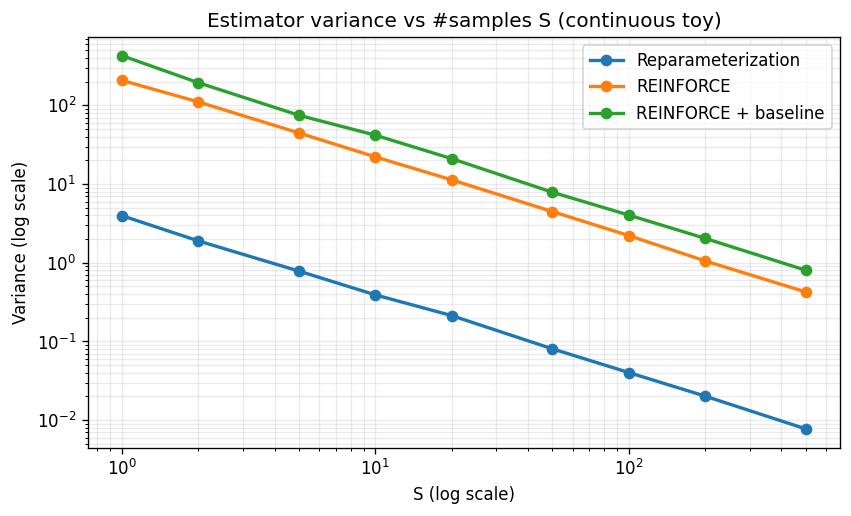

In [ ]:

S_grid = np.array([1,2,5,10,20,50,100,200,500])
R = 3000

rng = np.random.default_rng(1)
vars_reparam=[]
vars_score=[]
vars_score_b=[]

for S in S_grid:
    gr=[]; gs=[]; gsb=[]
    for _ in range(R):
        gr.append(grad_reparam(mu0, S, rng))
        gs.append(grad_score(mu0, S, rng, baseline=None))
        gsb.append(grad_score(mu0, S, rng, baseline=b_opt))
    vars_reparam.append(np.var(gr))
    vars_score.append(np.var(gs))
    vars_score_b.append(np.var(gsb))

plt.figure(figsize=(7.2,4.4))
plt.loglog(S_grid, vars_reparam, marker='o', lw=2, label='Reparameterization')
plt.loglog(S_grid, vars_score, marker='o', lw=2, label='REINFORCE')
plt.loglog(S_grid, vars_score_b, marker='o', lw=2, label='REINFORCE + baseline')
plt.title('Estimator variance vs #samples S (continuous toy)')
plt.xlabel('S (log scale)')
plt.ylabel('Variance (log scale)')
plt.grid(True, which='both', alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_reparam_assets/figures/variance_vs_S_continuous.png')
plt.show()


## 3) Histogram of estimates (continuous, S=10)

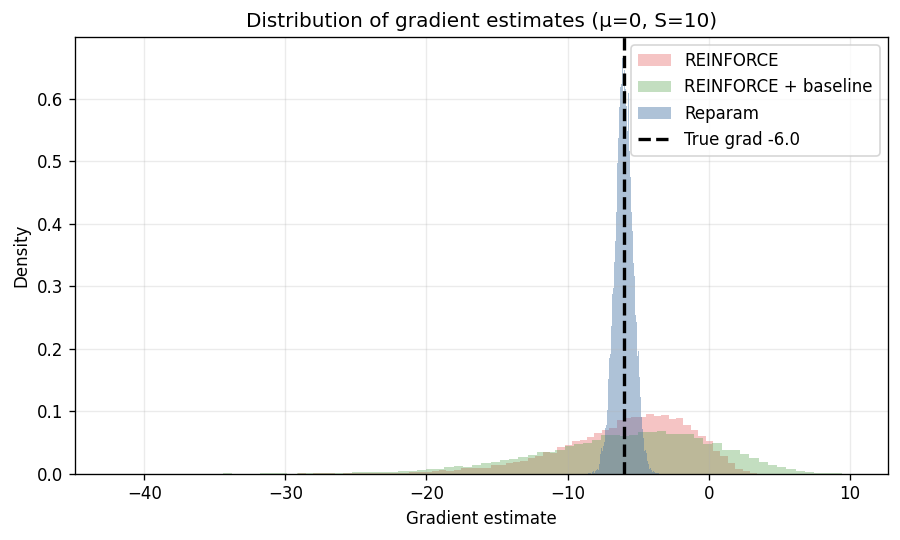

In [ ]:

S = 10
rng = np.random.default_rng(2)
reps = 20000
true_g = grad_true(mu0)

reparam = np.array([grad_reparam(mu0, S, rng) for _ in range(reps)])
score = np.array([grad_score(mu0, S, rng) for _ in range(reps)])
score_b = np.array([grad_score(mu0, S, rng, baseline=b_opt) for _ in range(reps)])

plt.figure(figsize=(7.6,4.6))
bins=80
plt.hist(score, bins=bins, density=True, alpha=0.35, label='REINFORCE', color='#E45756')
plt.hist(score_b, bins=bins, density=True, alpha=0.35, label='REINFORCE + baseline', color='#54A24B')
plt.hist(reparam, bins=bins, density=True, alpha=0.45, label='Reparam', color='#4C78A8')
plt.axvline(true_g, color='k', linestyle='--', lw=2, label=f'True grad {true_g:.1f}')
plt.title('Distribution of gradient estimates (μ=0, S=10)')
plt.xlabel('Gradient estimate')
plt.ylabel('Density')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_reparam_assets/figures/hist_grad_estimates.png')
plt.show()



## 4) Discrete example: Bernoulli + REINFORCE baseline

Let $z\sim\text{Bernoulli}(p)$ and objective $J(p)=\mathbb{E}[z]=p$.
If we parameterize with logit $\alpha$ where $p=\sigma(\alpha)$, the true gradient is
$\frac{dJ}{d\alpha}=p(1-p).$

REINFORCE gradient wrt $\alpha$:
$g=(f(z)-b)(z-p),\quad f(z)=z.$
A good baseline is $b\approx\mathbb{E}[z]=p$.


True grad dJ/dlogit: 0.16000000000000003


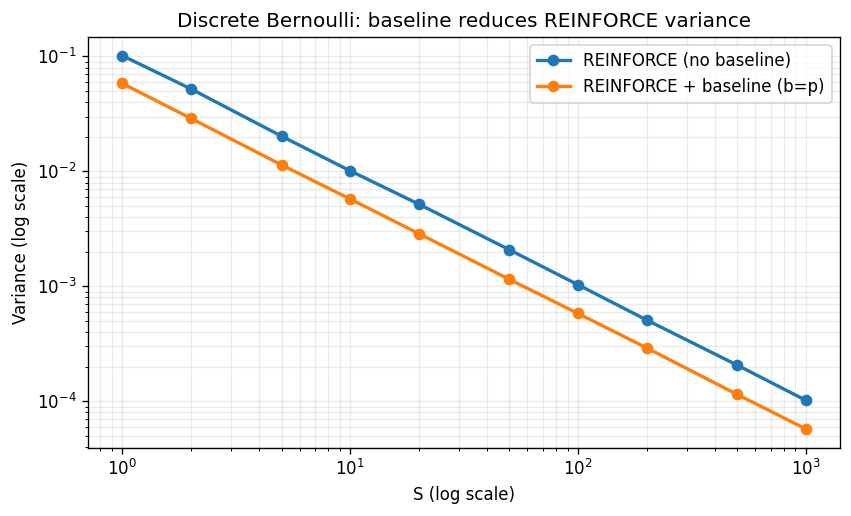

In [ ]:


def reinforce_bernoulli(p, S, rng, baseline=None):
    z = (rng.random(S) < p).astype(float)
    score = z - p
    fz = z
    if baseline is None:
        g = fz*score
    else:
        g = (fz-baseline)*score
    return g.mean()

p0 = 0.2
true_grad_logit = p0*(1-p0)
print('True grad dJ/dlogit:', true_grad_logit)

S_grid2 = np.array([1,2,5,10,20,50,100,200,500,1000])
R=20000
rng = np.random.default_rng(3)
vars_plain=[]
vars_base=[]

for S in S_grid2:
    g1=[]; g2=[]
    for _ in range(R):
        g1.append(reinforce_bernoulli(p0, S, rng, baseline=None))
        g2.append(reinforce_bernoulli(p0, S, rng, baseline=p0))
    vars_plain.append(np.var(g1))
    vars_base.append(np.var(g2))

plt.figure(figsize=(7.2,4.4))
plt.loglog(S_grid2, vars_plain, marker='o', lw=2, label='REINFORCE (no baseline)')
plt.loglog(S_grid2, vars_base, marker='o', lw=2, label='REINFORCE + baseline (b=p)')
plt.title('Discrete Bernoulli: baseline reduces REINFORCE variance')
plt.xlabel('S (log scale)')
plt.ylabel('Variance (log scale)')
plt.grid(True, which='both', alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('vi_reparam_assets/figures/bernoulli_reinforce_variance.png')
plt.show()



## 5) Key takeaway for VAEs

VAE ELBO:
$\mathcal{L}=\mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)]-\mathrm{KL}(q_\phi(z\mid x)\|p(z)).$

Reparameterization:
$z=\mu_\phi(x)+\sigma_\phi(x)\odot\epsilon,\quad \epsilon\sim\mathcal{N}(0,I).$

This makes gradients w.r.t. $\phi$ flow through $z$, enabling minibatch SGD.



# SVI Recipe Example (Fixed)

You reported divergence in the previous black-box SVI run (mean blow-up, sigma collapsing to 0).
That can happen when minibatch scaling ($N/B$) creates very large gradients.

This notebook uses a more robust setup:
- PyTorch autograd (avoids algebra mistakes)
- Adam optimizer
- gradient clipping
- clamping log(sigma)

We keep the same toy model and verify convergence to the known posterior.

Figures are saved into `vi_svi_recipe_assets_fixed/figures/`.


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import torch

os.makedirs('vi_svi_recipe_assets_fixed/figures', exist_ok=True)
plt.rcParams['figure.dpi'] = 120

# Data
rng = np.random.default_rng(42)
N = 50000
true_theta = 1.2
sigma = 1.0
x = rng.normal(true_theta, sigma, size=N).astype(np.float32)

# Prior
mu0 = 0.0
lambda0 = 1.0

# Exact posterior (validation)
post_lambda = lambda0 + N/(sigma**2)
post_mu = (lambda0*mu0 + np.sum(x)/(sigma**2)) / post_lambda
post_var = 1/post_lambda
post_std = float(np.sqrt(post_var))

print('Posterior mean:', post_mu)
print('Posterior std :', post_std)


Posterior mean: 1.1994457
Posterior std : 0.004472091234310839



## Black-box SVI (reparameterization + Adam)

We maximize the (scaled) minibatch ELBO estimate:
$\widehat{\mathcal{L}} = \mathbb{E}_q[\log p(\theta)] + \frac{N}{B}\sum_{b\in\mathcal{B}}\mathbb{E}_q[\log p(x_b\mid\theta)] - \mathbb{E}_q[\log q(\theta)].$

Stability tricks:
- Adam, gradient clipping, and clamping log(sigma).


In [ ]:


def blackbox_svi_torch(x, batch_size=512, S=8, iters=1500, lr=5e-3, seed=0, clip=10.0):
    torch.manual_seed(seed)
    x_t = torch.tensor(x)
    N = x_t.shape[0]

    mu = torch.zeros((), requires_grad=True)
    log_sigma = torch.zeros((), requires_grad=True)

    opt = torch.optim.Adam([mu, log_sigma], lr=lr)

    mu_hist=[]; sig_hist=[]; elbo_hist=[]

    for t in range(iters):
        idx = torch.randint(0, N, (batch_size,))
        xb = x_t[idx]

        eps = torch.randn(S)
        sigma_q = torch.exp(log_sigma).clamp(min=1e-6)
        theta = mu + sigma_q*eps

        logp_theta = 0.5*torch.log(torch.tensor(lambda0)) - 0.5*lambda0*(theta-mu0)**2
        ll = -0.5*N*torch.log(torch.tensor(sigma**2)) - 0.5*(N/batch_size)*torch.sum((xb[None,:]-theta[:,None])**2, dim=1)/(sigma**2)
        logq = -log_sigma - 0.5*((theta-mu)/sigma_q)**2

        elbo = torch.mean(logp_theta + ll - logq)
        loss = -elbo

        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_([mu, log_sigma], max_norm=clip)
        opt.step()

        with torch.no_grad():
            log_sigma.clamp_(min=-12.0, max=2.0)

        mu_hist.append(mu.item())
        sig_hist.append(torch.exp(log_sigma).item())
        elbo_hist.append(elbo.item())

    return np.array(mu_hist), np.array(sig_hist), np.array(elbo_hist)

mu_bb, sig_bb, elbo_bb = blackbox_svi_torch(x)
print('Final mu:', mu_bb[-1], 'Final sigma:', sig_bb[-1])


Final mu: 1.193966269493103 Final sigma: 0.024697061628103256


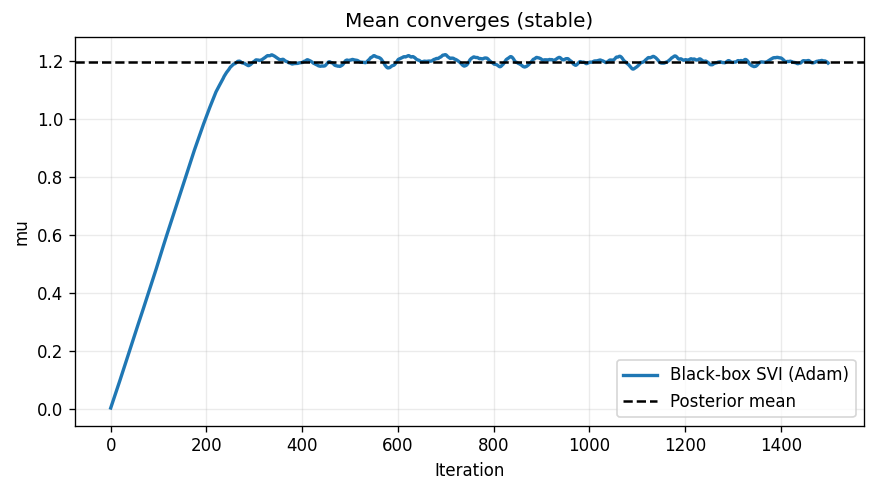

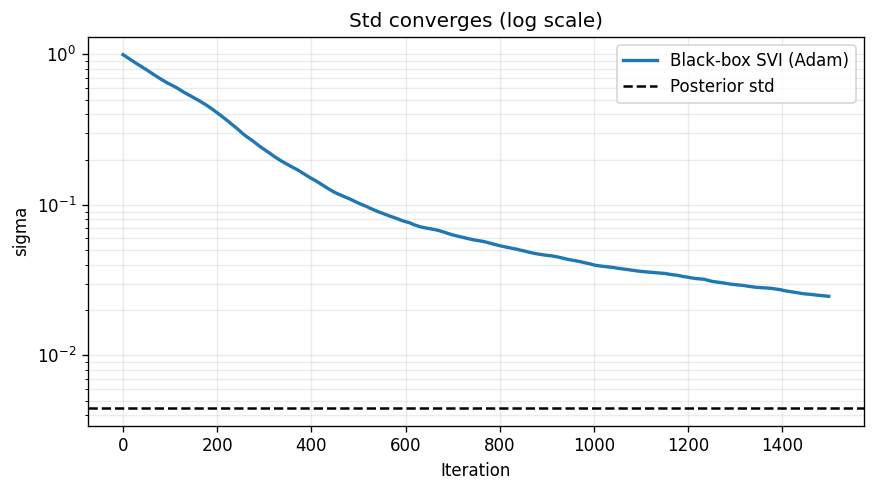

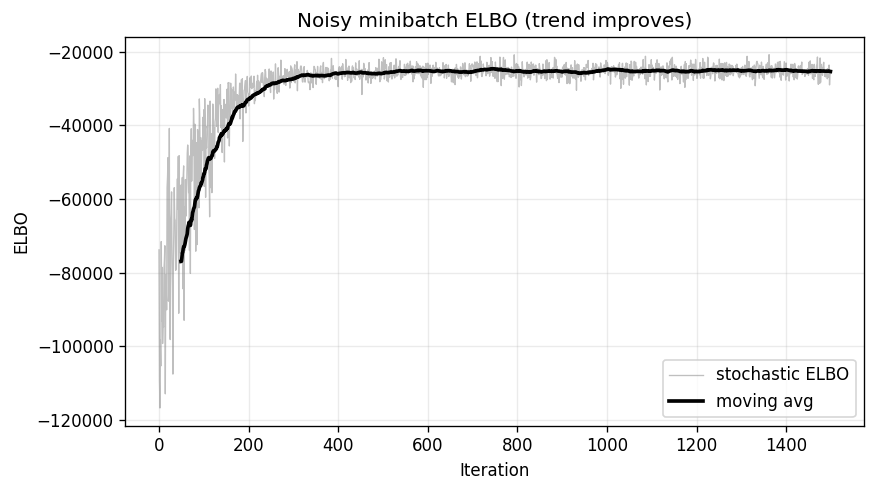

In [ ]:

# Plots
window = 50
ma = np.convolve(elbo_bb, np.ones(window)/window, mode='valid')

plt.figure(figsize=(7.4,4.2))
plt.plot(mu_bb, lw=2, label='Black-box SVI (Adam)')
plt.axhline(post_mu, color='k', linestyle='--', label='Posterior mean')
plt.title('Mean converges (stable)')
plt.xlabel('Iteration'); plt.ylabel('mu')
plt.grid(True, alpha=0.25); plt.legend(); plt.tight_layout()
plt.savefig('vi_svi_recipe_assets_fixed/figures/bb_svi_mu.png')
plt.show()

plt.figure(figsize=(7.4,4.2))
plt.plot(sig_bb, lw=2, label='Black-box SVI (Adam)')
plt.axhline(post_std, color='k', linestyle='--', label='Posterior std')
plt.yscale('log')
plt.title('Std converges (log scale)')
plt.xlabel('Iteration'); plt.ylabel('sigma')
plt.grid(True, which='both', alpha=0.25); plt.legend(); plt.tight_layout()
plt.savefig('vi_svi_recipe_assets_fixed/figures/bb_svi_sigma.png')
plt.show()

plt.figure(figsize=(7.4,4.2))
plt.plot(elbo_bb, lw=0.8, color='gray', alpha=0.5, label='stochastic ELBO')
plt.plot(np.arange(window-1, window-1+len(ma)), ma, lw=2.2, color='black', label='moving avg')
plt.title('Noisy minibatch ELBO (trend improves)')
plt.xlabel('Iteration'); plt.ylabel('ELBO')
plt.grid(True, alpha=0.25); plt.legend(); plt.tight_layout()
plt.savefig('vi_svi_recipe_assets_fixed/figures/bb_svi_elbo.png')
plt.show()



## Natural-gradient SVI (EMA) for comparison

Because the model is conjugate, we can update natural parameters using an exponential moving average.


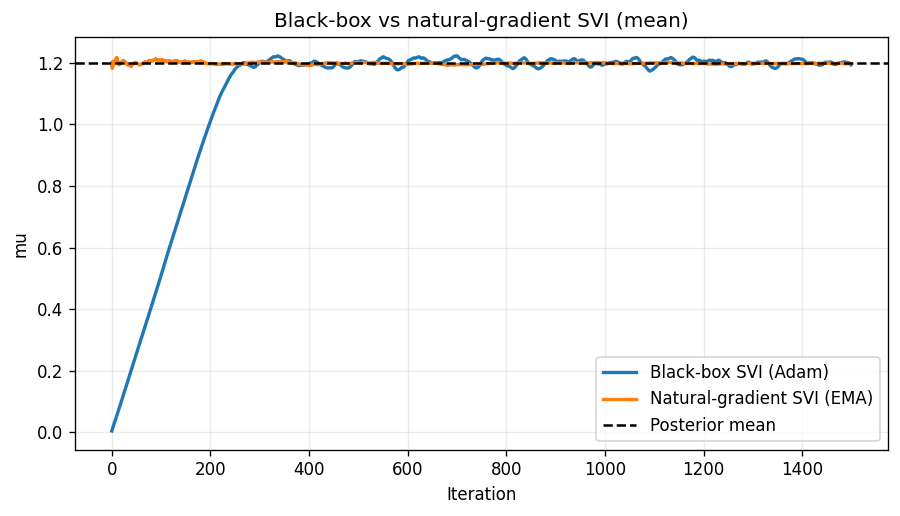

In [ ]:


def svi_natural(x, batch_size=512, iters=1500, tau=50, kappa=0.7, seed=1):
    r = np.random.default_rng(seed)
    N = len(x)
    mu, lam = 0.0, 1.0
    mu_hist=[]
    for t in range(1, iters+1):
        rho_t = (t+tau)**(-kappa)
        idx = r.choice(N, size=batch_size, replace=False)
        xb = x[idx]
        sum_xb = np.sum(xb)

        lam_hat = lambda0 + N/(sigma**2)
        eta1_hat = lambda0*mu0 + (N/batch_size)*sum_xb/(sigma**2)

        eta1 = lam*mu
        eta1 = (1-rho_t)*eta1 + rho_t*eta1_hat
        lam  = (1-rho_t)*lam  + rho_t*lam_hat
        mu = eta1/lam
        mu_hist.append(mu)
    return np.array(mu_hist)

mu_ng = svi_natural(x)

plt.figure(figsize=(7.6,4.4))
plt.plot(mu_bb, lw=2, label='Black-box SVI (Adam)')
plt.plot(mu_ng, lw=2, label='Natural-gradient SVI (EMA)')
plt.axhline(post_mu, color='k', linestyle='--', label='Posterior mean')
plt.title('Black-box vs natural-gradient SVI (mean)')
plt.xlabel('Iteration'); plt.ylabel('mu')
plt.grid(True, alpha=0.25); plt.legend(); plt.tight_layout()
plt.savefig('vi_svi_recipe_assets_fixed/figures/svi_compare_mu.png')
plt.show()
